In [44]:
!pip install tensorflow-gpu==1.13.1

ERROR: Could not find a version that satisfies the requirement tensorflow-gpu==1.13.1 (from versions: 2.5.0, 2.5.1, 2.5.2, 2.5.3, 2.6.0, 2.6.1, 2.6.2, 2.6.3, 2.6.4, 2.6.5, 2.7.0rc0, 2.7.0rc1, 2.7.0, 2.7.1, 2.7.2, 2.7.3, 2.7.4, 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.12.0)
ERROR: No matching distribution found for tensorflow-gpu==1.13.1


In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:150% !important; }</style>"))

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Reshape, Activation
from tensorflow.keras.layers import BatchNormalization, MaxPooling2D, Dropout
from tensorflow.keras.layers import UpSampling2D, Conv2D, Concatenate, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG

import os, warnings
warnings.filterwarnings('ignore')

In [3]:
IMAGE_WIDTH = 64
IMAGE_HEIGHT = 64
IMAGE_CHANNELS = 1
CONDITIONAL_IMAGE_CHANNELS = 10
BATCH_SIZE = 32
LATENT_DIMENSION = 100
IMAGE_SHAPE = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)
CONDITIONAL_IMAGE_SHAPE = (IMAGE_WIDTH, IMAGE_HEIGHT, CONDITIONAL_IMAGE_CHANNELS)
EPOCHS = 100

In [4]:
INPUT_FEATURES = ['elevation', 'wind_speed', 'wind_dir', 'tmin', 'tmax',
                  'landcover', 'precip', 'pdsi','solar', 'PrevFireMask']

In [5]:
man_length = 21550

MinMax = {'landcover':(10.0, 100.0),
              'tmax': (-41.95404185202824, 35.28747487720835),
              'tmin': (-42.4077221254351, 34.710974191122716),
              'wind_speed': (0.0002993076576944125, 14.27423496286687),
              'elevation': (-77.85292, 4379.4683),
              'wind_direction': (-179.99999083334689, 179.99999810000588),
              'solar_radiation': (-24.598765964771623, 964662.1183104622),
              'air_pressure': (99064.73425290409, 105551.80433948596),
              'precipitation': (-9.494998975299606e-05, 0.012117456275976952)}

In [6]:
def _parse_function(proto):

    keys_to_features = {
        'feature1': tf.io.VarLenFeature(tf.float32),
        'feature2': tf.io.VarLenFeature(tf.float32),
        'feature3': tf.io.VarLenFeature(tf.float32),
        'feature4': tf.io.VarLenFeature(tf.float32),
        'feature5': tf.io.VarLenFeature(tf.float32),
        'feature6': tf.io.VarLenFeature(tf.float32),
        'feature7': tf.io.VarLenFeature(tf.float32),
        'feature8': tf.io.VarLenFeature(tf.float32),
        'feature9': tf.io.VarLenFeature(tf.float32),
        'feature10': tf.io.VarLenFeature(tf.float32),
        'label': tf.io.VarLenFeature(tf.float32)
    }

    # Load one example
    parsed_features = tf.io.parse_single_example(proto, keys_to_features)

    feature_list = []
    for i in range(1, 11):
        #tf.print(f"feature {i}, shape : {tf.shape(tf.sparse.to_dense(parsed_features[f'feature{i}']))}")
        feature = tf.zeros([64, 64], tf.float32)
        tensor = tf.sparse.to_dense(parsed_features[f'feature{i}'])
        if tf.shape(tensor) == [4096]:
            feature = tf.reshape(tf.sparse.to_dense(parsed_features[f'feature{i}']), [64, 64])
        feature_list.append(feature)

    combined_features = tf.stack(feature_list, axis=-1)
    label = tf.zeros([64, 64], tf.float32)
    #tf.print(f"label, shape : {tf.shape(tf.sparse.to_dense(parsed_features[f'label']))}")
    label = tf.zeros([64, 64], tf.float32)
    tensor = tf.sparse.to_dense(parsed_features[f'label'])
    if tf.shape(tensor) == [4096]:
        label = tf.reshape(tf.sparse.to_dense(parsed_features['label']), [64, 64])
    

    return combined_features, label

In [7]:
def count_records(tfrecord_file):
    count = 0
    for _ in tf.data.TFRecordDataset(tfrecord_file):
        count += 1
    return count

In [8]:
import tensorflow as tf
# Number of images and labels in your dataset
num_examples = 21550
#num_examples = 20

# Output file name
tfrecord_file = 'data/data2.tfrecords'

In [9]:
count_records(tfrecord_file)

21550

In [10]:
dataset = tf.data.TFRecordDataset(tfrecord_file)

dataset = dataset.map(_parse_function)

In [11]:
dataset = dataset.shuffle(buffer_size=man_length)
train_size = int(0.8 * man_length)
val_size = int(0.2 * man_length)

# Split the dataset
train_dataset = dataset.take(train_size)
remaining_dataset = dataset.skip(train_size)
eval_dataset = remaining_dataset.take(val_size // 2)
test_dataset = remaining_dataset.skip(val_size // 2)

train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
eval_dataset = eval_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
from matplotlib import colors

inputs, labels = next(iter(train_dataset))
print(f"inputs.shape: {inputs.shape}")
print(f"labels.shape: {labels.shape}")

TITLES = ['PrevFireMask', 'elevation', 'wind_speed', 'air\npressure', 'wind_dir', 'tmax', 'tmin',
                  'solar', 'precip', 'landcover',  'Fire\nmask']
print(f"len(TITLES): {len(TITLES)}")


# Number of rows of data samples to plot
n_rows = 5
# Number of data variables
n_features = inputs.shape[3]
# Variables for controllong the color map for the fire masks
CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
BOUNDS = [-1, -0.1, 0.001, 1]
NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)


fig = plt.figure(figsize=(15,6.5))

for i in range(n_rows):
    for j in range(n_features + 1):
        plt.subplot(n_rows, n_features + 1, i * (n_features + 1) + j + 1)
        if i == 0:
            plt.title(TITLES[j], fontsize=13)
        if j == 0:
            plt.imshow(inputs[i, :, :, 0], cmap=CMAP, norm=NORM)
        if j > 0 and j < n_features:
            plt.imshow(inputs[i, :, :, j], cmap='viridis')
        
        if j == n_features:
            plt.imshow(labels[i, :, :], cmap=CMAP, norm=NORM) 
        plt.axis('off')
plt.tight_layout()
plt.show()

In [12]:
from tensorflow.keras import regularizers
def build_generator(latent_dimension, conditional_image_shape):
    
    # Noise Input Layers
    noise_input_placeholder = Input(shape = (latent_dimension, ))
    x = Dense(1024)(noise_input_placeholder)
    x = Activation('leaky_relu')(x)
    x = Dense(128 * 16 * 16, kernel_regularizer=regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    noise_input = Reshape((16, 16, 128), input_shape = (128 * 16 * 16, ))(x)
    
    # # Condition Input Layers
    # condition_input_placeholder = Input(shape = (latent_dimension, ))
    # x = Dense(1024)(condition_input_placeholder)
    # x = Activation('tanh')(x)
    # x = Dense(128 * 7 * 7)(x)
    # x = BatchNormalization()(x)
    # condition_input = Reshape((7, 7, 128), input_shape = (128 * 7 * 7, ))(x)

    # Condition Image Layers
    condition_input_placeholder = Input(conditional_image_shape)
    x = Conv2D(64, (5, 5), padding = 'same')(condition_input_placeholder)
    x = BatchNormalization()(x)
    x = Activation('leaky_relu')(x)
    x = MaxPooling2D(pool_size = (2, 2))(x)
    x = Conv2D(128, (5, 5), padding = 'same')(x)
    x = BatchNormalization()(x)
    x = Activation('leaky_relu')(x)
    condition_input = MaxPooling2D(pool_size = (2, 2))(x)
    
    # Combined Input
    combined_input = Concatenate()([noise_input, condition_input])
    
    # Generator Block 1
    x = UpSampling2D(size = (2, 2))(combined_input)
    x = Conv2D(64, (5, 5), padding = 'same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Generator Block 2
    x = UpSampling2D(size = (2, 2))(x)
    x = Conv2D(1, (5, 5), padding = 'same')(x)
    x = BatchNormalization()(x)
    output = Activation('tanh')(x)
    
    generator = Model([noise_input_placeholder, condition_input_placeholder], output, name = 'Generator')
    
    return generator

In [13]:
def build_discriminator(image_shape, conditional_image_shape, latent_dimension):
    
    # Image Input Layers
    image_input_placeholder = Input(image_shape)
    x = Conv2D(64, (5, 5), padding = 'same')(image_input_placeholder)
    x = Activation('leaky_relu')(x)
    x = MaxPooling2D(pool_size = (2, 2))(x)
    x = Conv2D(128, (5, 5))(x)
    x = Activation('leaky_relu')(x)
    image_input = MaxPooling2D(pool_size = (2, 2))(x)
    
    # Previous Condition Input Layers
    # condition_input_placeholder = Input(shape = (latent_dimension, ))
    # x = Dense(1024)(condition_input_placeholder)
    # x = Activation('tanh')(x)
    # x = Dense(128 * 12 * 12)(x)
    # x = BatchNormalization()(x)
    # condition_input = Reshape((12, 12, 128), input_shape = (128 * 12 * 12, ))(x)
    
    # Condition Image Layers
    condition_input_placeholder = Input(conditional_image_shape)
    x = Conv2D(64, (5, 5), padding = 'same')(condition_input_placeholder)
    x = Activation('leaky_relu')(x)
    x = MaxPooling2D(pool_size = (2, 2))(x)
    x = Conv2D(128, (5, 5))(x)
    x = Activation('leaky_relu')(x)
    condition_input = MaxPooling2D(pool_size = (2, 2))(x)
    
    combined_input = Concatenate()([image_input, condition_input])

    x = Conv2D(64, (5, 5), padding = 'same')(combined_input)
    x = BatchNormalization()(x)
    x = Activation('leaky_relu')(x)
    x = Flatten()(combined_input)
    dropout = Dropout(0.4)(x)
    x = Dense(1024, kernel_regularizer=regularizers.l2(0.001))(dropout)
    x = Activation('leaky_relu')(x)
    output = Dense(1, activation = 'sigmoid')(x)
    
    discriminator = Model([image_input_placeholder, condition_input_placeholder], output, name = 'Discriminator')
    
    return discriminator

In [14]:
def build_gan(generator, discriminator, image_shape, conditional_image_shape, latent_dimension):
    noise_input_placeholder = Input(shape = (latent_dimension, ), name = 'NoiseInput')
    condition_input_placeholder = Input(shape = (conditional_image_shape), name = 'ConditionInput')
    generated_image = generator([noise_input_placeholder, condition_input_placeholder])
    discriminator.trainable = False
    validity = discriminator([generated_image, condition_input_placeholder])
    gan = Model([noise_input_placeholder, condition_input_placeholder], validity)
    return gan

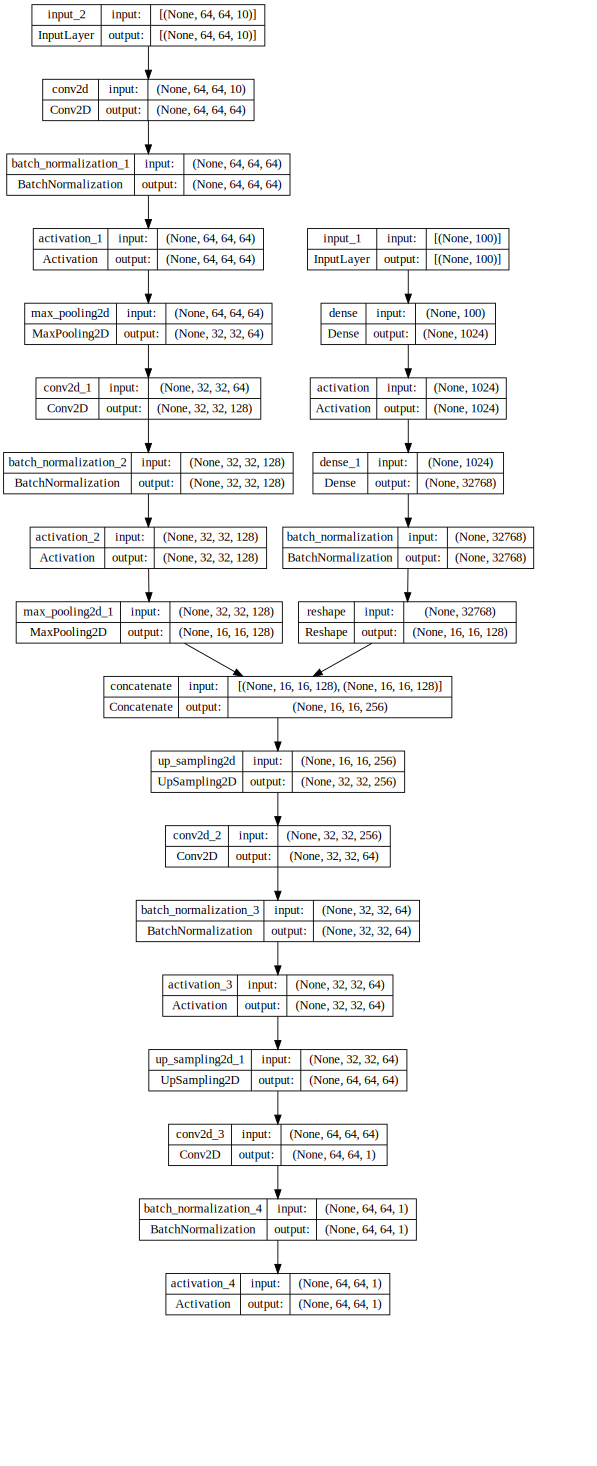

In [15]:
generator = build_generator(100, CONDITIONAL_IMAGE_SHAPE)
SVG(model_to_dot(generator, show_shapes = True, show_layer_names = True,dpi=65).create(prog = 'dot', format = 'svg'))

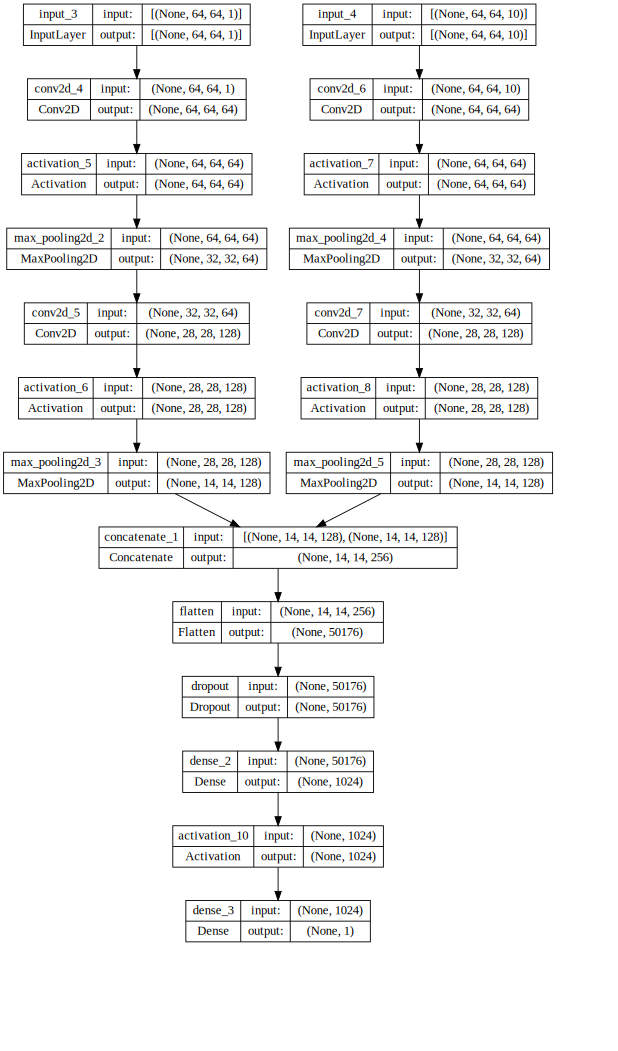

In [16]:
discriminator = build_discriminator((64, 64, 1), CONDITIONAL_IMAGE_SHAPE, 100)
SVG(model_to_dot(discriminator, show_shapes = True, show_layer_names = True, dpi=65).create(prog = 'dot', format = 'svg'))

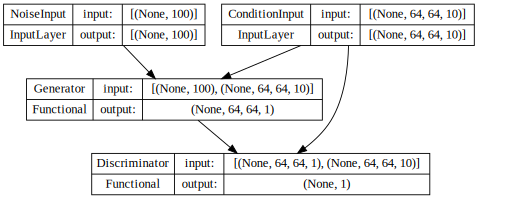

In [17]:
gan = build_gan(generator, discriminator, (64, 64, 1), CONDITIONAL_IMAGE_SHAPE, 100)
SVG(model_to_dot(gan, show_shapes = True, show_layer_names = True, dpi=65).create(prog = 'dot', format = 'svg'))

In [18]:
optimizer = Adam(0.0001, 0.5, clipnorm=1)

In [19]:
generator.compile(loss = 'binary_crossentropy', optimizer = optimizer)
gan.compile(loss = 'binary_crossentropy', optimizer = optimizer)
discriminator.trainable = True
discriminator.compile(loss = 'binary_crossentropy', optimizer = optimizer)

In [20]:
gpu_available = tf.test.is_gpu_available()
print(gpu_available)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True


In [21]:
from tqdm.notebook import tqdm

t = train_size
for epoch in range(EPOCHS):
    
    progress_bar = tqdm(desc = "Epoch: {0}".format(epoch), total = t)
    
    generator_loss_history, discriminator_loss_history = [], []
    
    for batch_labels, batch_images in train_dataset:
        if batch_labels.shape[0] != BATCH_SIZE or np.isnan(batch_labels).any() or np.isnan(batch_images).any():
            continue
        
        noise = np.random.uniform(0, 1, size = (BATCH_SIZE, LATENT_DIMENSION))
        
        # Get a Batch from the dataset
        # batch_images = x_train[iteration * BATCH_SIZE : (iteration + 1) * BATCH_SIZE]
        # batch_labels = y_train[iteration * BATCH_SIZE : (iteration + 1) * BATCH_SIZE]
        
        # Fake Images
        generated_images = generator.predict([noise, batch_labels])
        batch_images = np.expand_dims(batch_images, axis=-1)
        
        # Batch Dataset
        x = np.concatenate((batch_images, generated_images))
        y = np.array([1] * BATCH_SIZE + [0] * BATCH_SIZE)
        discriminator_conditions = np.concatenate((batch_labels, batch_labels))
        
        # Training the Discriminator
        discriminator_loss = discriminator.train_on_batch([x, discriminator_conditions], y)
        discriminator_loss_history.append(discriminator_loss)
        print(discriminator_loss)
        
        noise = np.random.uniform(0, 1, size = (BATCH_SIZE, LATENT_DIMENSION))
        
        # Training the Generator
        discriminator.trainable = False
        generator_loss = gan.train_on_batch([noise, batch_labels], np.array([1] * BATCH_SIZE))
        generator_loss_history.append(generator_loss)
        print(generator_loss)
        discriminator.trainable = True
        
        progress_bar.update(BATCH_SIZE)

Epoch: 0:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 3s 3s/step
2.703190326690674
5.189486980438232
1/1 [==============================] - 0s 25ms/step
2.661538600921631
7.764979362487793
1/1 [==============================] - 0s 23ms/step
2.8822083473205566
5.821472644805908
1/1 [==============================] - 0s 19ms/step
2.4895498752593994
7.637731552124023
1/1 [==============================] - 0s 24ms/step
2.3504574298858643
6.880175590515137
1/1 [==============================] - 0s 19ms/step
2.1460554599761963
9.336891174316406
1/1 [==============================] - 0s 24ms/step
2.1125030517578125
8.983253479003906
1/1 [==============================] - 0s 23ms/step
2.2221052646636963
12.679213523864746
1/1 [==============================] - 0s 21ms/step
2.1137638092041016
16.153099060058594
1/1 [==============================] - 0s 23ms/step
2.0229053497314453
15.0022554397583
1/1 [==============================] - 0s 24ms/step
1.9009120464324951
14.973835945129395
1/1 [==================

Epoch: 1:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step
0.05628674104809761
10.599019050598145
1/1 [==============================] - 0s 23ms/step
0.05616900324821472
8.767545700073242
1/1 [==============================] - 0s 23ms/step
0.05173379182815552
8.76370620727539
1/1 [==============================] - 0s 23ms/step
0.04950927197933197
10.334550857543945
1/1 [==============================] - 0s 23ms/step
0.04976053908467293
8.5015869140625
1/1 [==============================] - 0s 24ms/step
0.050347235053777695
8.286835670471191
1/1 [==============================] - 0s 22ms/step
0.048517826944589615
9.033248901367188
1/1 [==============================] - 0s 24ms/step
0.0488395020365715
10.04761791229248
1/1 [==============================] - 0s 26ms/step
0.05112408101558685
10.601716995239258
1/1 [==============================] - 0s 24ms/step
0.04835538566112518
10.174917221069336
1/1 [==============================] - 0s 23ms/step
0.04828699678182602
10.376218795776367
1/1 [==

Epoch: 2:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step
0.025797516107559204
8.326403617858887
1/1 [==============================] - 0s 20ms/step
0.024264739826321602
10.905125617980957
1/1 [==============================] - 0s 19ms/step
0.028515197336673737
12.120183944702148
1/1 [==============================] - 0s 24ms/step
0.17043405771255493
2.732405185699463
1/1 [==============================] - 0s 18ms/step
0.04609362781047821
10.001106262207031
1/1 [==============================] - 0s 28ms/step
0.03306511789560318
9.663644790649414
1/1 [==============================] - 0s 22ms/step
0.04344760626554489
11.993284225463867
1/1 [==============================] - 0s 18ms/step
0.05807599425315857
11.266095161437988
1/1 [==============================] - 0s 20ms/step
0.030131056904792786
5.478209018707275
1/1 [==============================] - 0s 22ms/step
0.05523846298456192
10.31030559539795
1/1 [==============================] - 0s 22ms/step
0.035857174545526505
11.243925094604492

Epoch: 3:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step
0.018415208905935287
15.644081115722656
1/1 [==============================] - 0s 20ms/step
0.018843475729227066
9.788787841796875
1/1 [==============================] - 0s 21ms/step
0.020516037940979004
10.988749504089355
1/1 [==============================] - 0s 20ms/step
0.027294985949993134
12.564313888549805
1/1 [==============================] - 0s 21ms/step
0.02272305265069008
15.91421890258789
1/1 [==============================] - 0s 20ms/step
0.02347353659570217
15.154151916503906
1/1 [==============================] - 0s 20ms/step
0.025762435048818588
17.266103744506836
1/1 [==============================] - 0s 22ms/step
0.025060104206204414
13.136820793151855
1/1 [==============================] - 0s 20ms/step
0.031930748373270035
6.750179767608643
1/1 [==============================] - 0s 20ms/step
0.019622456282377243
17.323869705200195
1/1 [==============================] - 0s 20ms/step
0.023865606635808945
9.1159715652

Epoch: 4:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step
0.02838718704879284
7.246738910675049
1/1 [==============================] - 0s 20ms/step
0.025869492441415787
7.840982437133789
1/1 [==============================] - 0s 23ms/step
0.02456478215754032
4.581655979156494
1/1 [==============================] - 0s 20ms/step
0.024510834366083145
5.773585796356201
1/1 [==============================] - 0s 18ms/step
0.025146281346678734
10.519450187683105
1/1 [==============================] - 0s 21ms/step
0.033563148230314255
9.08113956451416
1/1 [==============================] - 0s 21ms/step
0.02828037180006504
19.74266815185547
1/1 [==============================] - 0s 19ms/step
0.03184514492750168
31.595947265625
1/1 [==============================] - 0s 20ms/step
0.02287047728896141
4.119058132171631
1/1 [==============================] - 0s 20ms/step
0.027191389352083206
5.695912837982178
1/1 [==============================] - 0s 21ms/step
0.033071424812078476
11.551345825195312
1/1 [

Epoch: 5:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step
0.020274493843317032
11.821993827819824
1/1 [==============================] - 0s 19ms/step
0.02164497785270214
10.556464195251465
1/1 [==============================] - 0s 18ms/step
0.17514412105083466
20.908716201782227
1/1 [==============================] - 0s 19ms/step
0.1547585278749466
23.781829833984375
1/1 [==============================] - 0s 19ms/step
0.025277115404605865
12.103414535522461
1/1 [==============================] - 0s 18ms/step
0.024096695706248283
11.859010696411133
1/1 [==============================] - 0s 19ms/step
0.024347860366106033
11.906610488891602
1/1 [==============================] - 0s 18ms/step
0.02427772991359234
9.186088562011719
1/1 [==============================] - 0s 21ms/step
0.02468969114124775
4.88429594039917
1/1 [==============================] - 0s 23ms/step
0.0237420741468668
14.683928489685059
1/1 [==============================] - 0s 22ms/step
0.024048540741205215
8.476957321166992


Epoch: 6:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step
0.054662592709064484
45.889564514160156
1/1 [==============================] - 0s 22ms/step
0.0657026469707489
19.810834884643555
1/1 [==============================] - 0s 21ms/step
0.051698848605155945
13.700650215148926
1/1 [==============================] - 0s 27ms/step
0.062101058661937714
12.360383987426758
1/1 [==============================] - 0s 22ms/step
0.03693392500281334
12.59164047241211
1/1 [==============================] - 0s 25ms/step
0.042297184467315674
11.558103561401367
1/1 [==============================] - 0s 23ms/step
0.04584425315260887
10.9824800491333
1/1 [==============================] - 0s 27ms/step
0.07708636671304703
60.627891540527344
1/1 [==============================] - 0s 22ms/step
0.04157599061727524
43.651275634765625
1/1 [==============================] - 0s 20ms/step
0.03911519795656204
12.106840133666992
1/1 [==============================] - 0s 21ms/step
0.047760702669620514
18.76566314697265

Epoch: 7:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step
0.03383874148130417
20.33847427368164
1/1 [==============================] - 0s 20ms/step
0.026445146650075912
12.52065658569336
1/1 [==============================] - 0s 20ms/step
0.033756323158741
19.638296127319336
1/1 [==============================] - 0s 18ms/step
0.03071415051817894
7.604959011077881
1/1 [==============================] - 0s 20ms/step
0.02594093792140484
6.832953929901123
1/1 [==============================] - 0s 19ms/step
0.027534950524568558
13.334755897521973
1/1 [==============================] - 0s 21ms/step
0.026489654555916786
5.517739772796631
1/1 [==============================] - 0s 20ms/step
0.02184605598449707
31.580101013183594
1/1 [==============================] - 0s 19ms/step
0.021582990884780884
15.85112476348877
1/1 [==============================] - 0s 19ms/step
0.02390383742749691
23.40690040588379
1/1 [==============================] - 0s 21ms/step
0.022390855476260185
16.034099578857422
1/1

Epoch: 8:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step
0.04086118936538696
12.121600151062012
1/1 [==============================] - 0s 19ms/step
0.04072243720293045
13.764667510986328
1/1 [==============================] - 0s 19ms/step
0.04048573970794678
20.364004135131836
1/1 [==============================] - 0s 23ms/step
0.03457411006093025
10.423070907592773
1/1 [==============================] - 0s 19ms/step
0.03683086112141609
33.34492111206055
1/1 [==============================] - 0s 21ms/step
0.04258032515645027
51.553184509277344
1/1 [==============================] - 0s 22ms/step
0.13968399167060852
8.368496894836426
1/1 [==============================] - 0s 20ms/step
0.046503946185112
33.100860595703125
1/1 [==============================] - 0s 19ms/step
0.0546075701713562
10.882171630859375
1/1 [==============================] - 0s 18ms/step
0.03791915997862816
5.675965785980225
1/1 [==============================] - 0s 20ms/step
0.04541165381669998
12.084381103515625
1/1 [

Epoch: 9:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step
0.20963162183761597
19.710411071777344
1/1 [==============================] - 0s 20ms/step
0.17131713032722473
38.8482551574707
1/1 [==============================] - 0s 21ms/step
0.17686884105205536
18.940217971801758
1/1 [==============================] - 0s 18ms/step
0.329836368560791
19.2757511138916
1/1 [==============================] - 0s 20ms/step
0.08832161873579025
17.12026023864746
1/1 [==============================] - 0s 19ms/step
0.18012690544128418
27.257659912109375
1/1 [==============================] - 0s 19ms/step
0.08269911259412766
17.814598083496094
1/1 [==============================] - 0s 20ms/step
0.11637036502361298
11.350394248962402
1/1 [==============================] - 0s 19ms/step
0.09043751657009125
11.38168716430664
1/1 [==============================] - 0s 20ms/step
0.04167921096086502
14.564961433410645
1/1 [==============================] - 0s 18ms/step
0.11559747159481049
32.81183624267578
1/1 [===

Epoch: 10:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step
0.06104223430156708
19.871984481811523
1/1 [==============================] - 0s 21ms/step
0.06227247789502144
21.946414947509766
1/1 [==============================] - 0s 20ms/step
0.045692358165979385
15.554303169250488
1/1 [==============================] - 0s 19ms/step
0.0707128643989563
14.030924797058105
1/1 [==============================] - 0s 20ms/step
0.09971419721841812
53.70590591430664
1/1 [==============================] - 0s 19ms/step
0.11722899973392487
9.403913497924805
1/1 [==============================] - 0s 22ms/step
0.1659778356552124
6.37888765335083
1/1 [==============================] - 0s 21ms/step
0.09213121235370636
38.505462646484375
1/1 [==============================] - 0s 21ms/step
0.03915037587285042
35.726375579833984
1/1 [==============================] - 0s 19ms/step
0.118796706199646
23.884593963623047
1/1 [==============================] - 0s 20ms/step
0.10710850358009338
17.11760902404785
1/1 [==

Epoch: 11:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step
0.05566071718931198
16.72838020324707
1/1 [==============================] - 0s 22ms/step
0.07706607133150101
12.9534330368042
1/1 [==============================] - 0s 20ms/step
0.08025547862052917
177.3409423828125
1/1 [==============================] - 0s 26ms/step
0.3245390057563782
89.62796020507812
1/1 [==============================] - 0s 20ms/step
0.3082450032234192
19.234420776367188
1/1 [==============================] - 0s 20ms/step
0.20029649138450623
13.697256088256836
1/1 [==============================] - 0s 18ms/step
0.056238822638988495
18.094579696655273
1/1 [==============================] - 0s 22ms/step
0.13934999704360962
15.167962074279785
1/1 [==============================] - 0s 19ms/step
0.11237406730651855
9.610980033874512
1/1 [==============================] - 0s 20ms/step
0.05181527137756348
20.0316219329834
1/1 [==============================] - 0s 19ms/step
0.042104993015527725
25.822500228881836
1/1 [==

Epoch: 12:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step
0.031334131956100464
62.58455276489258
1/1 [==============================] - 0s 23ms/step
0.03123394213616848
25.311960220336914
1/1 [==============================] - 0s 18ms/step
0.031049776822328568
8.125325202941895
1/1 [==============================] - 0s 20ms/step
0.031249577179551125
5.881315231323242
1/1 [==============================] - 0s 19ms/step
0.03115357644855976
7.870644569396973
1/1 [==============================] - 0s 18ms/step
0.030760644003748894
66.14076232910156
1/1 [==============================] - 0s 20ms/step
0.030453702434897423
25.80792808532715
1/1 [==============================] - 0s 21ms/step
0.030369136482477188
89.32402801513672
1/1 [==============================] - 0s 19ms/step
0.03018362447619438
19.108951568603516
1/1 [==============================] - 0s 19ms/step
0.030072417110204697
12.531373977661133
1/1 [==============================] - 0s 22ms/step
0.03018507920205593
11.069808959960938

Epoch: 13:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step
0.028530122712254524
24.174373626708984
1/1 [==============================] - 0s 20ms/step
0.027597708627581596
16.564123153686523
1/1 [==============================] - 0s 20ms/step
0.39461633563041687
7.801943302154541
1/1 [==============================] - 0s 21ms/step
0.5370236039161682
13.813264846801758
1/1 [==============================] - 0s 19ms/step
0.49349141120910645
27.533000946044922
1/1 [==============================] - 0s 20ms/step
2.7815377712249756
17.12265968322754
1/1 [==============================] - 0s 19ms/step
0.9447530508041382
10.607705116271973
1/1 [==============================] - 0s 22ms/step
0.21758419275283813
12.31220531463623
1/1 [==============================] - 0s 20ms/step
0.09671910852193832
10.787434577941895
1/1 [==============================] - 0s 23ms/step
0.12559929490089417
11.10914134979248
1/1 [==============================] - 0s 21ms/step
0.07035638391971588
8.536645889282227
1/1 [

Epoch: 14:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step
0.03709365800023079
19.35610008239746
1/1 [==============================] - 0s 23ms/step
0.0606682114303112
15.157569885253906
1/1 [==============================] - 0s 21ms/step
0.041022151708602905
20.440031051635742
1/1 [==============================] - 0s 19ms/step
0.039607420563697815
22.65553855895996
1/1 [==============================] - 0s 19ms/step
0.03863062337040901
17.1085147857666
1/1 [==============================] - 0s 22ms/step
0.03860445320606232
10.97503662109375
1/1 [==============================] - 0s 19ms/step
0.03784395381808281
90.3188247680664
1/1 [==============================] - 0s 21ms/step
0.04190841317176819
15.91009521484375
1/1 [==============================] - 0s 21ms/step
0.04362335056066513
13.905083656311035
1/1 [==============================] - 0s 20ms/step
0.03897065669298172
22.50193214416504
1/1 [==============================] - 0s 19ms/step
0.04015422239899635
88.03022766113281
1/1 [===

Epoch: 15:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step
0.03288856893777847
15.118447303771973
1/1 [==============================] - 0s 20ms/step
0.030330877751111984
17.336503982543945
1/1 [==============================] - 0s 19ms/step
0.029811900109052658
17.127214431762695
1/1 [==============================] - 0s 19ms/step
0.029477616772055626
78.22014617919922
1/1 [==============================] - 0s 21ms/step
0.029584119096398354
34.936153411865234
1/1 [==============================] - 0s 21ms/step
0.057379718869924545
13.692536354064941
1/1 [==============================] - 0s 22ms/step
0.032774560153484344
19.64139175415039
1/1 [==============================] - 0s 23ms/step
0.038363147526979446
29.716928482055664
1/1 [==============================] - 0s 29ms/step
0.045885853469371796
14.139546394348145
1/1 [==============================] - 0s 19ms/step
0.03413281589746475
15.26941204071045
1/1 [==============================] - 0s 23ms/step
0.03268751502037048
12.9728908538

Epoch: 16:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step
0.05460718646645546
25.22100067138672
1/1 [==============================] - 0s 30ms/step
0.037188820540905
16.245073318481445
1/1 [==============================] - 0s 20ms/step
0.03562214598059654
12.018372535705566
1/1 [==============================] - 0s 20ms/step
0.032508734613657
13.109870910644531
1/1 [==============================] - 0s 20ms/step
0.03378167375922203
91.88594818115234
1/1 [==============================] - 0s 25ms/step
0.052308548241853714
62.75494384765625
1/1 [==============================] - 0s 21ms/step
0.04987077787518501
28.37021255493164
1/1 [==============================] - 0s 29ms/step
0.04865986108779907
10.125470161437988
1/1 [==============================] - 0s 23ms/step
0.05790380388498306
44.60838317871094
1/1 [==============================] - 0s 19ms/step
0.09238284081220627
21.789533615112305
1/1 [==============================] - 0s 20ms/step
0.08098789304494858
28.2453670501709
1/1 [====

Epoch: 17:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step
0.25850188732147217
22.864543914794922
1/1 [==============================] - 0s 21ms/step
0.08083933591842651
19.8111515045166
1/1 [==============================] - 0s 19ms/step
0.05710229277610779
15.722800254821777
1/1 [==============================] - 0s 19ms/step
0.0580827035009861
8.884449005126953
1/1 [==============================] - 0s 20ms/step
0.044438436627388
59.49345779418945
1/1 [==============================] - 0s 25ms/step
0.06056591123342514
111.8556137084961
1/1 [==============================] - 0s 20ms/step
0.15067055821418762
11.432698249816895
1/1 [==============================] - 0s 20ms/step
0.057264894247055054
19.255640029907227
1/1 [==============================] - 0s 20ms/step
0.3741788864135742
17.130842208862305
1/1 [==============================] - 0s 19ms/step
0.10128288716077805
28.4129581451416
1/1 [==============================] - 0s 20ms/step
0.07158855348825455
24.669559478759766
1/1 [====

Epoch: 18:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step
0.02879786118865013
11.967463493347168
1/1 [==============================] - 0s 25ms/step
0.029039351269602776
13.281054496765137
1/1 [==============================] - 0s 18ms/step
0.02852807193994522
8.118511199951172
1/1 [==============================] - 0s 20ms/step
0.061206527054309845
4.08204984664917
1/1 [==============================] - 0s 20ms/step
0.1770918071269989
19.379314422607422
1/1 [==============================] - 0s 24ms/step
0.03452666476368904
24.734220504760742
1/1 [==============================] - 0s 20ms/step
0.039257243275642395
24.762948989868164
1/1 [==============================] - 0s 25ms/step
0.10097526758909225
24.00408363342285
1/1 [==============================] - 0s 19ms/step
0.03898158296942711
15.689684867858887
1/1 [==============================] - 0s 20ms/step
0.06203761696815491
19.29920196533203
1/1 [==============================] - 0s 20ms/step
0.07548022270202637
15.296489715576172
1/

Epoch: 19:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step
0.021937115117907524
85.13306427001953
1/1 [==============================] - 0s 21ms/step
0.021881932392716408
33.94314956665039
1/1 [==============================] - 0s 20ms/step
0.021935926750302315
16.88148307800293
1/1 [==============================] - 0s 21ms/step
0.021948639303445816
16.562427520751953
1/1 [==============================] - 0s 23ms/step
0.021646108478307724
18.357906341552734
1/1 [==============================] - 0s 21ms/step
0.02175775170326233
15.056306838989258
1/1 [==============================] - 0s 30ms/step
0.021621907129883766
30.432161331176758
1/1 [==============================] - 0s 22ms/step
0.021491097286343575
13.369671821594238
1/1 [==============================] - 0s 20ms/step
0.021833844482898712
12.639418601989746
1/1 [==============================] - 0s 20ms/step
0.02218610607087612
24.720361709594727
1/1 [==============================] - 0s 25ms/step
0.02199501544237137
15.5198650360

Epoch: 20:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step
0.05958731472492218
18.67930030822754
1/1 [==============================] - 0s 22ms/step
0.023780735209584236
15.032514572143555
1/1 [==============================] - 0s 20ms/step
0.024480551481246948
21.818119049072266
1/1 [==============================] - 0s 22ms/step
0.023517411202192307
31.1389217376709
1/1 [==============================] - 0s 21ms/step
0.023941854014992714
16.506196975708008
1/1 [==============================] - 0s 27ms/step
0.023271344602108
28.173080444335938
1/1 [==============================] - 0s 20ms/step
0.036614350974559784
19.727476119995117
1/1 [==============================] - 0s 19ms/step
0.025382837280631065
10.370044708251953
1/1 [==============================] - 0s 20ms/step
0.023675447329878807
11.441731452941895
1/1 [==============================] - 0s 21ms/step
0.02328646555542946
21.170902252197266
1/1 [==============================] - 0s 19ms/step
0.023700401186943054
39.358783721923

Epoch: 21:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step
0.046100400388240814
10.205880165100098
1/1 [==============================] - 0s 21ms/step
0.0353374183177948
12.408814430236816
1/1 [==============================] - 0s 22ms/step
0.03484738618135452
17.241029739379883
1/1 [==============================] - 0s 21ms/step
0.09254500269889832
20.465633392333984
1/1 [==============================] - 0s 22ms/step
0.029333222657442093
28.33555030822754
1/1 [==============================] - 0s 24ms/step
0.0428486242890358
19.3610897064209
1/1 [==============================] - 0s 21ms/step
0.03807281702756882
16.238527297973633
1/1 [==============================] - 0s 20ms/step
0.029554981738328934
16.17354965209961
1/1 [==============================] - 0s 22ms/step
0.03660488873720169
21.89925765991211
1/1 [==============================] - 0s 21ms/step
0.044775545597076416
14.217719078063965
1/1 [==============================] - 0s 22ms/step
0.05074263736605644
19.267780303955078
1/

Epoch: 22:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step
0.11781289428472519
41.364463806152344
1/1 [==============================] - 0s 20ms/step
0.14741572737693787
33.953956604003906
1/1 [==============================] - 0s 21ms/step
0.13930627703666687
20.094594955444336
1/1 [==============================] - 0s 23ms/step
0.1664903461933136
11.105368614196777
1/1 [==============================] - 0s 21ms/step
0.21784180402755737
13.7406005859375
1/1 [==============================] - 0s 29ms/step
0.6256309151649475
22.45430564880371
1/1 [==============================] - 0s 21ms/step
0.10632912814617157
24.836198806762695
1/1 [==============================] - 0s 20ms/step
0.177461639046669
14.695821762084961
1/1 [==============================] - 0s 19ms/step
0.2594465911388397
18.443592071533203
1/1 [==============================] - 0s 23ms/step
0.3907380998134613
11.205499649047852
1/1 [==============================] - 0s 20ms/step
0.16081131994724274
12.901433944702148
1/1 [===

Epoch: 23:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step
0.016501659527420998
9.935688018798828
1/1 [==============================] - 0s 23ms/step
0.015944266691803932
11.901867866516113
1/1 [==============================] - 0s 20ms/step
0.015986816957592964
50.55129623413086
1/1 [==============================] - 0s 23ms/step
0.015513471327722073
11.927427291870117
1/1 [==============================] - 0s 21ms/step
0.017948182299733162
21.38614845275879
1/1 [==============================] - 0s 24ms/step
0.01562941074371338
13.614521980285645
1/1 [==============================] - 0s 23ms/step
0.016004575416445732
12.172053337097168
1/1 [==============================] - 0s 24ms/step
0.015231935307383537
14.99917221069336
1/1 [==============================] - 0s 20ms/step
0.015156017616391182
13.012594223022461
1/1 [==============================] - 0s 21ms/step
0.015087919309735298
25.454002380371094
1/1 [==============================] - 0s 23ms/step
0.01497062761336565
9.24183082580

Epoch: 24:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step
0.09258867800235748
15.180973052978516
1/1 [==============================] - 0s 20ms/step
0.0786680355668068
21.206298828125
1/1 [==============================] - 0s 21ms/step
0.04177345335483551
42.603084564208984
1/1 [==============================] - 0s 21ms/step
0.07668544352054596
15.716229438781738
1/1 [==============================] - 0s 20ms/step
0.06873054802417755
7.305897235870361
1/1 [==============================] - 0s 21ms/step
0.03292157128453255
32.50313949584961
1/1 [==============================] - 0s 22ms/step
0.14272350072860718
25.412641525268555
1/1 [==============================] - 0s 21ms/step
0.0754992663860321
20.24303436279297
1/1 [==============================] - 0s 19ms/step
0.17491188645362854
18.164562225341797
1/1 [==============================] - 0s 19ms/step
0.04103991761803627
20.01362419128418
1/1 [==============================] - 0s 19ms/step
0.41835716366767883
18.91841697692871
1/1 [====

Epoch: 25:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step
0.011845136061310768
21.5972957611084
1/1 [==============================] - 0s 19ms/step
0.011877928860485554
11.763928413391113
1/1 [==============================] - 0s 21ms/step
0.012602954171597958
24.336997985839844
1/1 [==============================] - 0s 24ms/step
0.011861076578497887
17.157922744750977
1/1 [==============================] - 0s 19ms/step
0.011632955633103848
36.44873046875
1/1 [==============================] - 0s 21ms/step
0.011752834543585777
12.17961597442627
1/1 [==============================] - 0s 24ms/step
0.011543532833456993
32.88815689086914
1/1 [==============================] - 0s 21ms/step
0.012565096840262413
7.87282133102417
1/1 [==============================] - 0s 20ms/step
0.011596412397921085
14.598576545715332
1/1 [==============================] - 0s 23ms/step
0.011723427101969719
11.588780403137207
1/1 [==============================] - 0s 21ms/step
0.011575947515666485
22.80199050903320

Epoch: 26:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step
0.04905301332473755
10.711555480957031
1/1 [==============================] - 0s 21ms/step
0.017025835812091827
34.772216796875
1/1 [==============================] - 0s 22ms/step
0.014847410842776299
29.721227645874023
1/1 [==============================] - 0s 19ms/step
0.015108156949281693
49.152313232421875
1/1 [==============================] - 0s 26ms/step
0.0564735010266304
19.779203414916992
1/1 [==============================] - 0s 22ms/step
0.04656154662370682
26.988407135009766
1/1 [==============================] - 0s 22ms/step
0.21460558474063873
15.250185012817383
1/1 [==============================] - 0s 22ms/step
0.018079331144690514
45.34374237060547
1/1 [==============================] - 0s 22ms/step
0.045085251331329346
35.04961395263672
1/1 [==============================] - 0s 20ms/step
0.18212738633155823
41.24734115600586
1/1 [==============================] - 0s 20ms/step
0.0664796382188797
23.64701271057129
1/1

Epoch: 27:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step
0.013466563075780869
7.839548587799072
1/1 [==============================] - 0s 21ms/step
0.013749764300882816
14.09570026397705
1/1 [==============================] - 0s 21ms/step
0.01343541219830513
12.185502052307129
1/1 [==============================] - 0s 19ms/step
0.013158882036805153
8.439362525939941
1/1 [==============================] - 0s 25ms/step
0.012963353656232357
16.119754791259766
1/1 [==============================] - 0s 21ms/step
0.01305275410413742
26.112655639648438
1/1 [==============================] - 0s 22ms/step
0.0168137289583683
22.89710235595703
1/1 [==============================] - 0s 21ms/step
0.015761634334921837
13.998091697692871
1/1 [==============================] - 0s 20ms/step
0.01393510028719902
14.327856063842773
1/1 [==============================] - 0s 21ms/step
0.013044605031609535
15.928499221801758
1/1 [==============================] - 0s 20ms/step
0.013827082701027393
18.1417236328125

Epoch: 28:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step
0.025189217180013657
21.248931884765625
1/1 [==============================] - 0s 21ms/step
0.022593744099140167
16.95328140258789
1/1 [==============================] - 0s 19ms/step
0.01991971768438816
11.809322357177734
1/1 [==============================] - 0s 23ms/step
0.019154755398631096
23.55531883239746
1/1 [==============================] - 0s 22ms/step
0.018854759633541107
11.593087196350098
1/1 [==============================] - 0s 20ms/step
0.030820876359939575
18.99642562866211
1/1 [==============================] - 0s 25ms/step
0.01680881157517433
7.695895195007324
1/1 [==============================] - 0s 20ms/step
0.016637196764349937
12.477331161499023
1/1 [==============================] - 0s 21ms/step
0.016272032633423805
24.35308265686035
1/1 [==============================] - 0s 21ms/step
0.04880373552441597
26.887447357177734
1/1 [==============================] - 0s 21ms/step
0.2896568775177002
15.51912784576416

Epoch: 29:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step
0.014383041299879551
6.87983512878418
1/1 [==============================] - 0s 20ms/step
0.014331098645925522
17.150283813476562
1/1 [==============================] - 0s 24ms/step
0.014247588813304901
14.66039752960205
1/1 [==============================] - 0s 21ms/step
0.014226976782083511
10.029167175292969
1/1 [==============================] - 0s 19ms/step
0.013983476907014847
23.037630081176758
1/1 [==============================] - 0s 21ms/step
0.014087765477597713
22.19947052001953
1/1 [==============================] - 0s 21ms/step
0.01391495019197464
12.625926971435547
1/1 [==============================] - 0s 20ms/step
0.014063862152397633
23.519655227661133
1/1 [==============================] - 0s 28ms/step
0.013594105839729309
9.303391456604004
1/1 [==============================] - 0s 24ms/step
0.013463118113577366
10.791749954223633
1/1 [==============================] - 0s 22ms/step
0.013547483831644058
16.7187595367

Epoch: 30:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step
0.07921990752220154
23.855192184448242
1/1 [==============================] - 0s 20ms/step
0.014700253494083881
15.322946548461914
1/1 [==============================] - 0s 20ms/step
0.014505811035633087
8.165543556213379
1/1 [==============================] - 0s 22ms/step
0.014875687658786774
8.842198371887207
1/1 [==============================] - 0s 21ms/step
0.013900983147323132
14.124675750732422
1/1 [==============================] - 0s 22ms/step
0.012871243059635162
11.494543075561523
1/1 [==============================] - 0s 22ms/step
0.014784343540668488
18.925037384033203
1/1 [==============================] - 0s 20ms/step
0.012379498220980167
27.0379638671875
1/1 [==============================] - 0s 19ms/step
0.014633766375482082
9.200847625732422
1/1 [==============================] - 0s 22ms/step
0.014950230717658997
20.644737243652344
1/1 [==============================] - 0s 21ms/step
0.01428978517651558
17.10593414306

Epoch: 31:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step
0.012009966187179089
26.48995018005371
1/1 [==============================] - 0s 21ms/step
0.012227065861225128
13.446027755737305
1/1 [==============================] - 0s 21ms/step
0.011784514412283897
20.43165397644043
1/1 [==============================] - 0s 22ms/step
0.01171116903424263
17.221494674682617
1/1 [==============================] - 0s 21ms/step
0.011852161958813667
21.265499114990234
1/1 [==============================] - 0s 20ms/step
0.011730780825018883
24.562726974487305
1/1 [==============================] - 0s 24ms/step
0.01164107397198677
11.192550659179688
1/1 [==============================] - 0s 23ms/step
0.011378400027751923
12.663235664367676
1/1 [==============================] - 0s 28ms/step
0.011984171345829964
11.679078102111816
1/1 [==============================] - 0s 20ms/step
0.011538085527718067
30.474105834960938
1/1 [==============================] - 0s 19ms/step
0.011903229169547558
17.81870460

Epoch: 32:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step
0.03232184424996376
17.280858993530273
1/1 [==============================] - 0s 22ms/step
0.034613944590091705
13.324075698852539
1/1 [==============================] - 0s 22ms/step
0.2367631494998932
10.239638328552246
1/1 [==============================] - 0s 23ms/step
0.03193197399377823
14.797821998596191
1/1 [==============================] - 0s 21ms/step
0.03998485207557678
11.243426322937012
1/1 [==============================] - 0s 24ms/step
0.03078264370560646
28.066919326782227
1/1 [==============================] - 0s 25ms/step
0.028650198131799698
22.818653106689453
1/1 [==============================] - 0s 20ms/step
0.03157913684844971
17.38100814819336
1/1 [==============================] - 0s 23ms/step
0.02988027222454548
17.859750747680664
1/1 [==============================] - 0s 25ms/step
0.02770206704735756
13.818058967590332
1/1 [==============================] - 0s 21ms/step
0.027145184576511383
28.49466323852539

Epoch: 33:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step
0.011864571832120419
16.00543212890625
1/1 [==============================] - 0s 23ms/step
0.011850656941533089
15.238774299621582
1/1 [==============================] - 0s 22ms/step
0.31357884407043457
12.233343124389648
1/1 [==============================] - 0s 21ms/step
0.08027505874633789
6.599185466766357
1/1 [==============================] - 0s 28ms/step
0.012345733121037483
21.864370346069336
1/1 [==============================] - 0s 23ms/step
0.01240762509405613
20.556961059570312
1/1 [==============================] - 0s 22ms/step
0.012650934047996998
16.48416519165039
1/1 [==============================] - 0s 19ms/step
0.012104904279112816
21.60050392150879
1/1 [==============================] - 0s 22ms/step
0.012762516736984253
8.629474639892578
1/1 [==============================] - 0s 21ms/step
0.012367899529635906
9.767300605773926
1/1 [==============================] - 0s 23ms/step
0.012434368953108788
7.82917833328247

Epoch: 34:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step
0.011195016093552113
15.992781639099121
1/1 [==============================] - 0s 34ms/step
0.011213644407689571
6.223794460296631
1/1 [==============================] - 0s 22ms/step
0.011261734180152416
19.753765106201172
1/1 [==============================] - 0s 22ms/step
0.011405637487769127
15.366825103759766
1/1 [==============================] - 0s 21ms/step
0.011041644960641861
13.279366493225098
1/1 [==============================] - 0s 22ms/step
0.011304027400910854
10.601410865783691
1/1 [==============================] - 0s 24ms/step
0.011015130206942558
18.289648056030273
1/1 [==============================] - 0s 21ms/step
0.01101034227758646
5.731907367706299
1/1 [==============================] - 0s 21ms/step
0.012590771540999413
9.388026237487793
1/1 [==============================] - 0s 23ms/step
0.010903196409344673
17.039098739624023
1/1 [==============================] - 0s 25ms/step
0.011097434908151627
16.80735588

Epoch: 35:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step
0.2378031313419342
15.393040657043457
1/1 [==============================] - 0s 21ms/step
0.21659493446350098
20.051315307617188
1/1 [==============================] - 0s 20ms/step
0.1313832849264145
12.277511596679688
1/1 [==============================] - 0s 22ms/step
0.044040076434612274
9.509437561035156
1/1 [==============================] - 0s 24ms/step
0.03582875058054924
12.932500839233398
1/1 [==============================] - 0s 27ms/step
0.02762557938694954
16.45594596862793
1/1 [==============================] - 0s 23ms/step
0.05132583528757095
17.879859924316406
1/1 [==============================] - 0s 21ms/step
0.03724326193332672
15.70920467376709
1/1 [==============================] - 0s 23ms/step
0.04921991378068924
9.928428649902344
1/1 [==============================] - 0s 20ms/step
0.09241354465484619
14.73001480102539
1/1 [==============================] - 0s 21ms/step
0.08730283379554749
26.984865188598633
1/1 [

Epoch: 36:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step
0.0197446346282959
16.474084854125977
1/1 [==============================] - 0s 20ms/step
0.02442198619246483
22.946399688720703
1/1 [==============================] - 0s 20ms/step
0.030928464606404305
11.684216499328613
1/1 [==============================] - 0s 21ms/step
0.036075808107852936
28.61481285095215
1/1 [==============================] - 0s 27ms/step
0.028596844524145126
11.207158088684082
1/1 [==============================] - 0s 21ms/step
0.042396605014801025
13.690279960632324
1/1 [==============================] - 0s 24ms/step
0.03672720491886139
18.402721405029297
1/1 [==============================] - 0s 23ms/step
0.024168599396944046
10.95656967163086
1/1 [==============================] - 0s 23ms/step
0.025447197258472443
28.40186309814453
1/1 [==============================] - 0s 21ms/step
0.04757676273584366
16.888198852539062
1/1 [==============================] - 0s 20ms/step
0.042338185012340546
13.884865760803

Epoch: 37:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step
0.024581115692853928
24.933012008666992
1/1 [==============================] - 0s 23ms/step
0.02717653661966324
26.047250747680664
1/1 [==============================] - 0s 21ms/step
0.02736692503094673
15.681464195251465
1/1 [==============================] - 0s 19ms/step
0.02414645627140999
10.278867721557617
1/1 [==============================] - 0s 20ms/step
0.023940056562423706
18.616878509521484
1/1 [==============================] - 0s 22ms/step
0.024774275720119476
20.16124725341797
1/1 [==============================] - 0s 24ms/step
0.03227055072784424
10.891518592834473
1/1 [==============================] - 0s 21ms/step
0.028635956346988678
17.554019927978516
1/1 [==============================] - 0s 22ms/step
0.029400235041975975
21.826814651489258
1/1 [==============================] - 0s 23ms/step
0.03782455623149872
17.569608688354492
1/1 [==============================] - 0s 24ms/step
0.02385769970715046
14.02130317687

Epoch: 38:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step
0.020172592252492905
10.177026748657227
1/1 [==============================] - 0s 21ms/step
0.018907269462943077
35.58818435668945
1/1 [==============================] - 0s 22ms/step
0.022838827222585678
25.119565963745117
1/1 [==============================] - 0s 22ms/step
0.027862530201673508
33.689449310302734
1/1 [==============================] - 0s 21ms/step
0.027838919311761856
16.011646270751953
1/1 [==============================] - 0s 23ms/step
0.023847145959734917
16.85374641418457
1/1 [==============================] - 0s 20ms/step
0.021493233740329742
23.31084632873535
1/1 [==============================] - 0s 27ms/step
0.029733123257756233
13.775911331176758
1/1 [==============================] - 0s 21ms/step
0.029032662510871887
12.511971473693848
1/1 [==============================] - 0s 22ms/step
0.03737809509038925
13.504302978515625
1/1 [==============================] - 0s 22ms/step
0.042958635836839676
9.324275970

Epoch: 39:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step
0.10920349508523941
9.279730796813965
1/1 [==============================] - 0s 23ms/step
0.027243541553616524
18.750022888183594
1/1 [==============================] - 0s 22ms/step
0.21180883049964905
17.7791690826416
1/1 [==============================] - 0s 22ms/step
0.026394734159111977
20.672191619873047
1/1 [==============================] - 0s 29ms/step
0.026569794863462448
13.760174751281738
1/1 [==============================] - 0s 21ms/step
0.02712191641330719
15.00636100769043
1/1 [==============================] - 0s 24ms/step
0.02611898072063923
27.181612014770508
1/1 [==============================] - 0s 21ms/step
0.025731945410370827
14.184524536132812
1/1 [==============================] - 0s 23ms/step
0.02566573955118656
13.720050811767578
1/1 [==============================] - 0s 21ms/step
0.02550186961889267
13.977381706237793
1/1 [==============================] - 0s 21ms/step
0.025403665378689766
21.1803035736084


Epoch: 40:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step
0.015294074080884457
6.133237838745117
1/1 [==============================] - 0s 23ms/step
0.014636321924626827
20.632965087890625
1/1 [==============================] - 0s 21ms/step
0.01582822948694229
16.006996154785156
1/1 [==============================] - 0s 24ms/step
0.016125913709402084
18.265077590942383
1/1 [==============================] - 0s 23ms/step
0.014980451203882694
15.887869834899902
1/1 [==============================] - 0s 22ms/step
0.014500215649604797
11.607183456420898
1/1 [==============================] - 0s 24ms/step
0.015321810729801655
12.58761978149414
1/1 [==============================] - 0s 22ms/step
0.014380354434251785
16.292861938476562
1/1 [==============================] - 0s 22ms/step
0.020579859614372253
33.74465560913086
1/1 [==============================] - 0s 22ms/step
0.01614869013428688
9.959975242614746
1/1 [==============================] - 0s 21ms/step
0.01500957366079092
16.31881904602

Epoch: 41:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step
0.056937672197818756
25.137115478515625
1/1 [==============================] - 0s 30ms/step
0.30036747455596924
12.464510917663574
1/1 [==============================] - 0s 22ms/step
0.04294645041227341
7.752774238586426
1/1 [==============================] - 0s 21ms/step
0.06092636659741402
18.29341697692871
1/1 [==============================] - 0s 20ms/step
0.20072761178016663
6.867374897003174
1/1 [==============================] - 0s 23ms/step
0.1285458505153656
11.100604057312012
1/1 [==============================] - 0s 26ms/step
0.18175101280212402
14.172734260559082
1/1 [==============================] - 0s 22ms/step
0.1355934888124466
12.541908264160156
1/1 [==============================] - 0s 28ms/step
0.3084711730480194
7.687367916107178
1/1 [==============================] - 0s 21ms/step
0.05944068729877472
16.847829818725586
1/1 [==============================] - 0s 21ms/step
0.06546913832426071
13.672322273254395
1/1 [

Epoch: 42:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step
0.020164279267191887
7.782190322875977
1/1 [==============================] - 0s 23ms/step
0.018786435946822166
11.59945297241211
1/1 [==============================] - 0s 26ms/step
0.021886566653847694
10.425830841064453
1/1 [==============================] - 0s 27ms/step
0.018779687583446503
15.210254669189453
1/1 [==============================] - 0s 28ms/step
0.0199836827814579
11.58066463470459
1/1 [==============================] - 0s 32ms/step
0.019552631303668022
17.280275344848633
1/1 [==============================] - 0s 26ms/step
0.019723962992429733
43.441871643066406
1/1 [==============================] - 0s 25ms/step
0.06700311601161957
6.156660556793213
1/1 [==============================] - 0s 29ms/step
0.031059827655553818
22.214866638183594
1/1 [==============================] - 0s 32ms/step
0.02987721562385559
8.585545539855957
1/1 [==============================] - 0s 31ms/step
0.11538878828287125
17.34517288208007

Epoch: 43:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step
0.03203744813799858
27.119548797607422
1/1 [==============================] - 0s 23ms/step
0.0837039202451706
14.746482849121094
1/1 [==============================] - 0s 26ms/step
0.06357070058584213
9.034168243408203
1/1 [==============================] - 0s 21ms/step
0.10045496374368668
21.774520874023438
1/1 [==============================] - 0s 27ms/step
0.04850320518016815
39.7661247253418
1/1 [==============================] - 0s 25ms/step
0.06488364934921265
34.258182525634766
1/1 [==============================] - 0s 23ms/step
0.06262145936489105
19.234067916870117
1/1 [==============================] - 0s 23ms/step
0.030980326235294342
17.50151824951172
1/1 [==============================] - 0s 25ms/step
0.028554217889904976
13.26115608215332
1/1 [==============================] - 0s 22ms/step
0.027190832421183586
46.951725006103516
1/1 [==============================] - 0s 23ms/step
0.06582799553871155
18.00078582763672
1/1

Epoch: 44:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step
0.09774203598499298
10.604223251342773
1/1 [==============================] - 0s 21ms/step
0.061949871480464935
13.402482032775879
1/1 [==============================] - 0s 26ms/step
0.050184935331344604
12.399989128112793
1/1 [==============================] - 0s 23ms/step
0.061531342566013336
8.88547134399414
1/1 [==============================] - 0s 22ms/step
0.06397919356822968
9.230573654174805
1/1 [==============================] - 0s 20ms/step
0.06308205425739288
11.0258150100708
1/1 [==============================] - 0s 22ms/step
0.03809879720211029
17.586471557617188
1/1 [==============================] - 0s 23ms/step
0.03860874101519585
21.349323272705078
1/1 [==============================] - 0s 23ms/step
0.07205972075462341
7.032474994659424
1/1 [==============================] - 0s 22ms/step
0.0781492069363594
15.210265159606934
1/1 [==============================] - 0s 25ms/step
0.12670011818408966
15.970321655273438
1/1

Epoch: 45:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step
0.01996312104165554
17.482393264770508
1/1 [==============================] - 0s 21ms/step
0.02003197744488716
9.546974182128906
1/1 [==============================] - 0s 23ms/step
0.019866837188601494
14.082030296325684
1/1 [==============================] - 0s 21ms/step
0.01984124630689621
38.05133819580078
1/1 [==============================] - 0s 22ms/step
0.01970459520816803
5.658665180206299
1/1 [==============================] - 0s 21ms/step
0.019976621493697166
8.513190269470215
1/1 [==============================] - 0s 22ms/step
0.019667478278279305
13.671406745910645
1/1 [==============================] - 0s 26ms/step
0.020454484969377518
10.751315116882324
1/1 [==============================] - 0s 24ms/step
0.01957317627966404
36.61640548706055
1/1 [==============================] - 0s 21ms/step
0.020338350906968117
7.945366859436035
1/1 [==============================] - 0s 22ms/step
0.019673222675919533
10.250811576843262

Epoch: 46:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step
0.01878090389072895
25.0673770904541
1/1 [==============================] - 0s 23ms/step
0.0385439395904541
16.0718994140625
1/1 [==============================] - 0s 21ms/step
0.02475157007575035
16.924402236938477
1/1 [==============================] - 0s 22ms/step
0.02969377487897873
13.641542434692383
1/1 [==============================] - 0s 25ms/step
0.030368568375706673
8.22418212890625
1/1 [==============================] - 0s 20ms/step
0.020935704931616783
16.876646041870117
1/1 [==============================] - 0s 29ms/step
0.044796936213970184
10.534050941467285
1/1 [==============================] - 0s 21ms/step
0.025233952328562737
28.06678009033203
1/1 [==============================] - 0s 20ms/step
0.024519985541701317
10.021880149841309
1/1 [==============================] - 0s 24ms/step
0.02267635427415371
27.15254783630371
1/1 [==============================] - 0s 25ms/step
0.02228769287467003
13.0733060836792
1/1 [

Epoch: 47:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step
0.011444555595517159
27.013940811157227
1/1 [==============================] - 0s 26ms/step
0.1081307977437973
4.825954914093018
1/1 [==============================] - 0s 25ms/step
0.011636667884886265
6.831821441650391
1/1 [==============================] - 0s 20ms/step
0.07158838212490082
7.181404113769531
1/1 [==============================] - 0s 24ms/step
0.011757776141166687
4.967225551605225
1/1 [==============================] - 0s 24ms/step
0.021152574568986893
28.596179962158203
1/1 [==============================] - 0s 26ms/step
0.012602576054632664
17.037996292114258
1/1 [==============================] - 0s 26ms/step
0.01221233420073986
30.358558654785156
1/1 [==============================] - 0s 22ms/step
0.0123311597853899
18.59720230102539
1/1 [==============================] - 0s 24ms/step
0.0122609818354249
16.873659133911133
1/1 [==============================] - 0s 22ms/step
0.01553768664598465
21.125595092773438
1/

Epoch: 48:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 51ms/step
0.010044598951935768
33.27988815307617
1/1 [==============================] - 0s 27ms/step
0.01042916625738144
15.117493629455566
1/1 [==============================] - 0s 28ms/step
0.012901272624731064
9.608908653259277
1/1 [==============================] - 0s 25ms/step
0.01257044542580843
18.023113250732422
1/1 [==============================] - 0s 20ms/step
0.010830129496753216
8.30777359008789
1/1 [==============================] - 0s 20ms/step
0.009801642969250679
13.843321800231934
1/1 [==============================] - 0s 19ms/step
0.009736745618283749
11.805253028869629
1/1 [==============================] - 0s 23ms/step
0.010473373346030712
8.890584945678711
1/1 [==============================] - 0s 30ms/step
0.009552834555506706
29.80524253845215
1/1 [==============================] - 0s 21ms/step
0.009714172221720219
11.03896713256836
1/1 [==============================] - 0s 22ms/step
0.00977248139679432
4.087399005889893

Epoch: 49:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step
0.018206892535090446
29.084360122680664
1/1 [==============================] - 0s 25ms/step
0.01773262955248356
14.270357131958008
1/1 [==============================] - 0s 23ms/step
0.016318872570991516
15.692288398742676
1/1 [==============================] - 0s 21ms/step
0.015867453068494797
10.281152725219727
1/1 [==============================] - 0s 23ms/step
0.020280757918953896
18.222694396972656
1/1 [==============================] - 0s 20ms/step
0.015210599638521671
10.676321029663086
1/1 [==============================] - 0s 23ms/step
0.01564173772931099
11.794878959655762
1/1 [==============================] - 0s 21ms/step
0.01609715446829796
4.553479194641113
1/1 [==============================] - 0s 23ms/step
0.021135641261935234
29.630802154541016
1/1 [==============================] - 0s 25ms/step
0.030785582959651947
33.401424407958984
1/1 [==============================] - 0s 24ms/step
0.028423383831977844
6.639415264

Epoch: 50:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step
0.010460331104695797
11.008344650268555
1/1 [==============================] - 0s 24ms/step
0.010307234711945057
10.794341087341309
1/1 [==============================] - 0s 25ms/step
0.0334307961165905
15.552656173706055
1/1 [==============================] - 0s 21ms/step
0.015486659482121468
3.1175973415374756
1/1 [==============================] - 0s 25ms/step
0.0249897800385952
11.308197975158691
1/1 [==============================] - 0s 24ms/step
0.01086964551359415
14.979437828063965
1/1 [==============================] - 0s 25ms/step
0.011477712541818619
11.28819751739502
1/1 [==============================] - 0s 21ms/step
0.010897713713347912
14.858348846435547
1/1 [==============================] - 0s 21ms/step
0.06375465542078018
18.161638259887695
1/1 [==============================] - 0s 27ms/step
0.010843025520443916
4.186448574066162
1/1 [==============================] - 0s 28ms/step
0.017593277618288994
19.854635238647

Epoch: 51:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step
0.016258379444479942
11.101970672607422
1/1 [==============================] - 0s 23ms/step
0.01685311086475849
8.753838539123535
1/1 [==============================] - 0s 24ms/step
0.016161369159817696
3.416215658187866
1/1 [==============================] - 0s 23ms/step
0.01639542542397976
10.512105941772461
1/1 [==============================] - 0s 24ms/step
0.016003724187612534
11.949896812438965
1/1 [==============================] - 0s 30ms/step
0.016359835863113403
6.870962619781494
1/1 [==============================] - 0s 29ms/step
0.017524555325508118
5.517191410064697
1/1 [==============================] - 0s 22ms/step
0.01579262875020504
10.766912460327148
1/1 [==============================] - 0s 22ms/step
0.015865245833992958
5.205630302429199
1/1 [==============================] - 0s 21ms/step
0.015681469812989235
10.788092613220215
1/1 [==============================] - 0s 33ms/step
0.015589911490678787
17.799713134765

Epoch: 52:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step
0.01472708210349083
16.025188446044922
1/1 [==============================] - 0s 26ms/step
0.014122139662504196
24.365869522094727
1/1 [==============================] - 0s 36ms/step
0.01402375753968954
17.005847930908203
1/1 [==============================] - 0s 22ms/step
0.0140488026663661
5.929133892059326
1/1 [==============================] - 0s 24ms/step
0.014402488246560097
14.81022834777832
1/1 [==============================] - 0s 22ms/step
0.013299105688929558
4.392611503601074
1/1 [==============================] - 0s 21ms/step
0.013379957526922226
27.240062713623047
1/1 [==============================] - 0s 29ms/step
0.013234716840088367
28.831939697265625
1/1 [==============================] - 0s 21ms/step
0.013352618552744389
4.412238121032715
1/1 [==============================] - 0s 23ms/step
0.013287590816617012
14.450472831726074
1/1 [==============================] - 0s 23ms/step
0.01376296766102314
10.5071754455566

Epoch: 53:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step
0.015431894920766354
14.593377113342285
1/1 [==============================] - 0s 27ms/step
0.015794964507222176
21.436460494995117
1/1 [==============================] - 0s 29ms/step
0.015499851666390896
4.148380756378174
1/1 [==============================] - 0s 21ms/step
0.015105635859072208
7.683467388153076
1/1 [==============================] - 0s 24ms/step
0.014842621050775051
4.401577472686768
1/1 [==============================] - 0s 24ms/step
0.014768549241125584
10.451382637023926
1/1 [==============================] - 0s 28ms/step
0.014750048518180847
27.783912658691406
1/1 [==============================] - 0s 24ms/step
0.014603345654904842
5.1694488525390625
1/1 [==============================] - 0s 21ms/step
0.014776705764234066
18.573745727539062
1/1 [==============================] - 0s 22ms/step
0.014471547678112984
9.538260459899902
1/1 [==============================] - 0s 22ms/step
0.014894377440214157
13.11716365

Epoch: 54:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step
0.33558523654937744
16.450775146484375
1/1 [==============================] - 0s 22ms/step
0.23167656362056732
21.87186622619629
1/1 [==============================] - 0s 25ms/step
0.3574746251106262
23.373760223388672
1/1 [==============================] - 0s 26ms/step
0.27304431796073914
18.57005500793457
1/1 [==============================] - 0s 30ms/step
0.2634292244911194
19.44434928894043
1/1 [==============================] - 0s 33ms/step
0.348909854888916
19.846590042114258
1/1 [==============================] - 0s 22ms/step
0.21443751454353333
8.998309135437012
1/1 [==============================] - 0s 31ms/step
0.14063382148742676
34.342769622802734
1/1 [==============================] - 0s 32ms/step
0.1157066747546196
5.1334147453308105
1/1 [==============================] - 0s 22ms/step
0.05283334106206894
49.084983825683594
1/1 [==============================] - 0s 24ms/step
0.030873844400048256
37.21760940551758
1/1 [===

Epoch: 55:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 34ms/step
0.010486219078302383
9.721649169921875
1/1 [==============================] - 0s 29ms/step
0.010647236369550228
5.076175212860107
1/1 [==============================] - 0s 29ms/step
0.010231218300759792
21.629140853881836
1/1 [==============================] - 0s 24ms/step
0.010612787678837776
5.091860771179199
1/1 [==============================] - 0s 24ms/step
0.012092714197933674
15.043970108032227
1/1 [==============================] - 0s 25ms/step
0.010603603906929493
11.402867317199707
1/1 [==============================] - 0s 26ms/step
0.010661637410521507
11.771147727966309
1/1 [==============================] - 0s 27ms/step
0.010306274518370628
9.304461479187012
1/1 [==============================] - 0s 27ms/step
0.010567196644842625
4.326169490814209
1/1 [==============================] - 0s 39ms/step
0.012185423634946346
9.86369514465332
1/1 [==============================] - 0s 24ms/step
0.010322611778974533
4.790982723236

Epoch: 56:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 35ms/step
0.018719499930739403
15.108223915100098
1/1 [==============================] - 0s 25ms/step
0.011274180375039577
18.736068725585938
1/1 [==============================] - 0s 25ms/step
0.011451355181634426
8.748635292053223
1/1 [==============================] - 0s 29ms/step
0.011773750185966492
16.11753273010254
1/1 [==============================] - 0s 22ms/step
0.011576833203434944
16.920677185058594
1/1 [==============================] - 0s 22ms/step
0.012824026867747307
18.700660705566406
1/1 [==============================] - 0s 21ms/step
0.011730911210179329
17.702306747436523
1/1 [==============================] - 0s 22ms/step
0.011817559599876404
8.476231575012207
1/1 [==============================] - 0s 24ms/step
0.011463790200650692
11.800581932067871
1/1 [==============================] - 0s 28ms/step
0.013997040688991547
13.317416191101074
1/1 [==============================] - 0s 26ms/step
0.012880953028798103
20.4444961

Epoch: 57:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step
0.011211440898478031
25.163860321044922
1/1 [==============================] - 0s 24ms/step
0.011565649881958961
8.942241668701172
1/1 [==============================] - 0s 24ms/step
0.011180680245161057
9.56793212890625
1/1 [==============================] - 0s 31ms/step
0.011286236345767975
33.89344787597656
1/1 [==============================] - 0s 32ms/step
0.011326007544994354
20.743175506591797
1/1 [==============================] - 0s 30ms/step
0.011411848478019238
18.994338989257812
1/1 [==============================] - 0s 23ms/step
0.01143021322786808
14.29744815826416
1/1 [==============================] - 0s 29ms/step
0.011168485507369041
11.108698844909668
1/1 [==============================] - 0s 25ms/step
0.011347157880663872
12.146501541137695
1/1 [==============================] - 0s 27ms/step
0.011341288685798645
4.153480529785156
1/1 [==============================] - 0s 23ms/step
0.012403907254338264
13.94084262847

Epoch: 58:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step
0.13409729301929474
1.3675457239151
1/1 [==============================] - 0s 23ms/step
0.007514970377087593
9.151427268981934
1/1 [==============================] - 0s 34ms/step
0.007991306483745575
10.26644229888916
1/1 [==============================] - 0s 30ms/step
0.07981730997562408
12.207291603088379
1/1 [==============================] - 0s 24ms/step
0.006968757137656212
6.51439905166626
1/1 [==============================] - 0s 46ms/step
0.007672161795198917
4.697012901306152
1/1 [==============================] - 0s 31ms/step
0.007530496921390295
13.122151374816895
1/1 [==============================] - 0s 26ms/step
0.0075454371981322765
14.897027015686035
1/1 [==============================] - 0s 25ms/step
0.008001979440450668
9.021578788757324
1/1 [==============================] - 0s 23ms/step
0.0072972956113517284
6.2456889152526855
1/1 [==============================] - 0s 25ms/step
0.007651238702237606
6.97250413894653

Epoch: 59:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step
0.031672462821006775
4.450697422027588
1/1 [==============================] - 0s 29ms/step
0.018040701746940613
1.661763310432434
1/1 [==============================] - 0s 23ms/step
0.012232990935444832
19.48126792907715
1/1 [==============================] - 0s 24ms/step
0.023824423551559448
2.8139877319335938
1/1 [==============================] - 0s 31ms/step
0.06921419501304626
4.435142517089844
1/1 [==============================] - 0s 29ms/step
0.09548059105873108
11.673151969909668
1/1 [==============================] - 0s 25ms/step
0.5053799748420715
24.35268783569336
1/1 [==============================] - 0s 36ms/step
0.028859511017799377
17.54217529296875
1/1 [==============================] - 0s 38ms/step
0.19409328699111938
20.416284561157227
1/1 [==============================] - 0s 27ms/step
0.12777061760425568
7.08081579208374
1/1 [==============================] - 0s 45ms/step
0.05263574793934822
13.451627731323242
1/1

Epoch: 60:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step
0.013807433657348156
8.241469383239746
1/1 [==============================] - 0s 28ms/step
0.013790163211524487
10.86337947845459
1/1 [==============================] - 0s 29ms/step
0.01713530719280243
11.861409187316895
1/1 [==============================] - 0s 25ms/step
0.013899249956011772
10.207630157470703
1/1 [==============================] - 0s 32ms/step
0.014948470517992973
3.0469491481781006
1/1 [==============================] - 0s 30ms/step
0.06938987970352173
11.424771308898926
1/1 [==============================] - 0s 27ms/step
0.013864460401237011
12.887256622314453
1/1 [==============================] - 0s 28ms/step
0.013879545032978058
6.329444408416748
1/1 [==============================] - 0s 29ms/step
0.013900508172810078
17.91045570373535
1/1 [==============================] - 0s 42ms/step
0.017449457198381424
6.16995906829834
1/1 [==============================] - 0s 29ms/step
0.018369270488619804
10.604130744934

Epoch: 61:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 34ms/step
0.010958985425531864
12.871524810791016
1/1 [==============================] - 0s 33ms/step
0.01090409979224205
7.445834636688232
1/1 [==============================] - 0s 34ms/step
0.010812642984092236
12.493346214294434
1/1 [==============================] - 0s 25ms/step
0.01096674706786871
20.5484619140625
1/1 [==============================] - 0s 40ms/step
0.010372250340878963
5.410389423370361
1/1 [==============================] - 0s 38ms/step
0.010594474151730537
10.921282768249512
1/1 [==============================] - 0s 28ms/step
0.01047101803123951
10.968589782714844
1/1 [==============================] - 0s 25ms/step
0.01038267370313406
7.97313928604126
1/1 [==============================] - 0s 30ms/step
0.010515009053051472
19.226865768432617
1/1 [==============================] - 0s 28ms/step
0.010599981062114239
17.99976921081543
1/1 [==============================] - 0s 26ms/step
0.01058189757168293
12.945109367370605


Epoch: 62:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 49ms/step
0.007434116210788488
18.11956214904785
1/1 [==============================] - 0s 27ms/step
0.0074479044415056705
11.341919898986816
1/1 [==============================] - 0s 37ms/step
0.007363929878920317
10.760788917541504
1/1 [==============================] - 0s 29ms/step
0.007568060420453548
4.060684680938721
1/1 [==============================] - 0s 25ms/step
0.007276023272424936
7.326749324798584
1/1 [==============================] - 0s 26ms/step
0.00719790905714035
7.684019088745117
1/1 [==============================] - 0s 35ms/step
0.0071136425249278545
5.648730278015137
1/1 [==============================] - 0s 28ms/step
0.007184399291872978
8.566088676452637
1/1 [==============================] - 0s 31ms/step
0.0071897851303219795
2.8735711574554443
1/1 [==============================] - 0s 24ms/step
0.007152549922466278
8.088842391967773
1/1 [==============================] - 0s 29ms/step
0.007291850633919239
10.671626091

Epoch: 63:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step
0.012992710806429386
2.6269781589508057
1/1 [==============================] - 0s 27ms/step
0.013193453662097454
3.4851644039154053
1/1 [==============================] - 0s 25ms/step
0.013048519380390644
33.84103775024414
1/1 [==============================] - 0s 30ms/step
0.013008316978812218
24.96029281616211
1/1 [==============================] - 0s 28ms/step
0.012952660210430622
16.097890853881836
1/1 [==============================] - 0s 34ms/step
0.012812008149921894
9.174032211303711
1/1 [==============================] - 0s 41ms/step
0.012727643363177776
9.121883392333984
1/1 [==============================] - 0s 34ms/step
0.012652980163693428
8.776208877563477
1/1 [==============================] - 0s 27ms/step
0.012631346471607685
8.893866539001465
1/1 [==============================] - 0s 32ms/step
0.013235274702310562
9.329289436340332
1/1 [==============================] - 0s 24ms/step
0.012831535190343857
8.242376327514

Epoch: 64:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 35ms/step
0.011745153926312923
3.3138153553009033
1/1 [==============================] - 0s 36ms/step
0.011659545823931694
22.866134643554688
1/1 [==============================] - 0s 31ms/step
0.011627423577010632
8.202195167541504
1/1 [==============================] - 0s 32ms/step
0.01179018896073103
10.049310684204102
1/1 [==============================] - 0s 35ms/step
0.012055064551532269
2.5950231552124023
1/1 [==============================] - 0s 28ms/step
0.012098326347768307
14.397903442382812
1/1 [==============================] - 0s 37ms/step
0.012026081793010235
14.74258041381836
1/1 [==============================] - 0s 30ms/step
0.011596672236919403
11.674772262573242
1/1 [==============================] - 0s 29ms/step
0.011593082919716835
13.122413635253906
1/1 [==============================] - 0s 34ms/step
0.01154007576406002
21.274747848510742
1/1 [==============================] - 0s 27ms/step
0.01154264248907566
13.593802452

Epoch: 65:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 38ms/step
0.016300257295370102
15.545412063598633
1/1 [==============================] - 0s 28ms/step
0.015843721106648445
21.485437393188477
1/1 [==============================] - 0s 26ms/step
0.01573958806693554
8.785040855407715
1/1 [==============================] - 0s 24ms/step
0.015675542876124382
41.05249786376953
1/1 [==============================] - 0s 29ms/step
0.05586554855108261
18.185903549194336
1/1 [==============================] - 0s 32ms/step
0.07189998030662537
10.418403625488281
1/1 [==============================] - 0s 26ms/step
0.10131767392158508
9.869912147521973
1/1 [==============================] - 0s 39ms/step
0.03149669989943504
18.328357696533203
1/1 [==============================] - 0s 25ms/step
0.025375688448548317
14.311549186706543
1/1 [==============================] - 0s 32ms/step
0.02563455142080784
16.28394889831543
1/1 [==============================] - 0s 24ms/step
0.020973997190594673
15.48530483245849

Epoch: 66:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step
0.013248002156615257
3.65934157371521
1/1 [==============================] - 0s 27ms/step
0.013145008124411106
9.135763168334961
1/1 [==============================] - 0s 35ms/step
0.013401391915977001
11.717103958129883
1/1 [==============================] - 0s 33ms/step
0.013039966113865376
3.019608974456787
1/1 [==============================] - 0s 36ms/step
0.012972001917660236
10.232025146484375
1/1 [==============================] - 0s 26ms/step
0.012876665219664574
12.052597999572754
1/1 [==============================] - 0s 30ms/step
0.012818417511880398
14.78895092010498
1/1 [==============================] - 0s 41ms/step
0.012792141176760197
12.728595733642578
1/1 [==============================] - 0s 33ms/step
0.012732182629406452
8.022026062011719
1/1 [==============================] - 0s 27ms/step
0.012684711255133152
15.431344985961914
1/1 [==============================] - 0s 34ms/step
0.012671289034187794
3.58795952796

Epoch: 67:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 45ms/step
0.0328703448176384
12.313471794128418
1/1 [==============================] - 0s 60ms/step
0.06318674236536026
15.864641189575195
1/1 [==============================] - 0s 44ms/step
0.09146164357662201
40.647884368896484
1/1 [==============================] - 0s 32ms/step
0.17282524704933167
19.827503204345703
1/1 [==============================] - 0s 25ms/step
0.7325210571289062
14.092235565185547
1/1 [==============================] - 0s 27ms/step
0.160363107919693
11.24094295501709
1/1 [==============================] - 0s 27ms/step
0.0744713619351387
12.040262222290039
1/1 [==============================] - 0s 32ms/step
0.02447008341550827
15.418230056762695
1/1 [==============================] - 0s 27ms/step
0.02389981970191002
15.442943572998047
1/1 [==============================] - 0s 28ms/step
0.023163268342614174
9.736873626708984
1/1 [==============================] - 0s 25ms/step
0.029109951108694077
15.41990852355957
1/1 [

Epoch: 68:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 42ms/step
0.016301199793815613
26.71889305114746
1/1 [==============================] - 0s 33ms/step
0.018664032220840454
16.063730239868164
1/1 [==============================] - 0s 28ms/step
0.04442685842514038
12.16130256652832
1/1 [==============================] - 0s 34ms/step
0.09228263795375824
7.632970333099365
1/1 [==============================] - 0s 35ms/step
0.1343390792608261
12.091567993164062
1/1 [==============================] - 0s 28ms/step
0.08480232208967209
12.036176681518555
1/1 [==============================] - 0s 32ms/step
0.1109849363565445
24.11937141418457
1/1 [==============================] - 0s 27ms/step
0.062464188784360886
12.116596221923828
1/1 [==============================] - 0s 28ms/step
0.08433902263641357
11.442062377929688
1/1 [==============================] - 0s 30ms/step
0.08218956738710403
11.13908863067627
1/1 [==============================] - 0s 29ms/step
0.07685855031013489
12.443136215209961
1/1

Epoch: 69:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step
0.015004300512373447
28.912734985351562
1/1 [==============================] - 0s 26ms/step
0.12002234160900116
11.287431716918945
1/1 [==============================] - 0s 42ms/step
0.09615428000688553
9.524107933044434
1/1 [==============================] - 0s 28ms/step
0.1177688017487526
16.3198184967041
1/1 [==============================] - 0s 28ms/step
0.07968129217624664
17.63796615600586
1/1 [==============================] - 0s 33ms/step
0.20127876102924347
14.818557739257812
1/1 [==============================] - 0s 47ms/step
0.03834395483136177
58.64809799194336
1/1 [==============================] - 0s 27ms/step
0.055889539420604706
11.098633766174316
1/1 [==============================] - 0s 36ms/step
0.04809827357530594
27.014606475830078
1/1 [==============================] - 0s 39ms/step
0.07277686148881912
38.346004486083984
1/1 [==============================] - 0s 35ms/step
0.028484046459197998
28.693065643310547
1/

Epoch: 70:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 42ms/step
0.009124224074184895
16.755001068115234
1/1 [==============================] - 0s 36ms/step
0.009099152870476246
1.5741645097732544
1/1 [==============================] - 0s 35ms/step
0.009061481803655624
9.049701690673828
1/1 [==============================] - 0s 25ms/step
0.009058279916644096
5.4362359046936035
1/1 [==============================] - 0s 27ms/step
0.009201579727232456
0.999534010887146
1/1 [==============================] - 0s 29ms/step
0.008976033888757229
1.1580408811569214
1/1 [==============================] - 0s 27ms/step
0.008947191759943962
21.650545120239258
1/1 [==============================] - 0s 33ms/step
0.008962896652519703
9.824281692504883
1/1 [==============================] - 0s 36ms/step
0.008938350714743137
6.185704708099365
1/1 [==============================] - 0s 34ms/step
0.008854617364704609
1.107851266860962
1/1 [==============================] - 0s 38ms/step
0.008832206949591637
10.752146720

Epoch: 71:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 36ms/step
0.012475789524614811
13.833332061767578
1/1 [==============================] - 0s 42ms/step
0.01268384326249361
12.285923957824707
1/1 [==============================] - 0s 30ms/step
0.01236624363809824
7.339622497558594
1/1 [==============================] - 0s 26ms/step
0.012386268936097622
11.250565528869629
1/1 [==============================] - 0s 34ms/step
0.012095876038074493
18.204185485839844
1/1 [==============================] - 0s 36ms/step
0.012159262783825397
32.476924896240234
1/1 [==============================] - 0s 27ms/step
0.011979120783507824
44.53239059448242
1/1 [==============================] - 0s 30ms/step
0.011982480064034462
25.91671371459961
1/1 [==============================] - 0s 39ms/step
0.011978832073509693
10.79572582244873
1/1 [==============================] - 0s 31ms/step
0.011766220442950726
3.2393767833709717
1/1 [==============================] - 0s 31ms/step
0.01172864343971014
3.997999668121

Epoch: 72:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 42ms/step
0.010965551249682903
9.663518905639648
1/1 [==============================] - 0s 31ms/step
0.010876547545194626
6.920856475830078
1/1 [==============================] - 0s 34ms/step
0.010830936953425407
11.310553550720215
1/1 [==============================] - 0s 31ms/step
0.010672437027096748
9.272961616516113
1/1 [==============================] - 0s 36ms/step
0.010829879902303219
11.439972877502441
1/1 [==============================] - 0s 27ms/step
0.010766440071165562
8.757396697998047
1/1 [==============================] - 0s 34ms/step
0.010710992850363255
3.64652681350708
1/1 [==============================] - 0s 28ms/step
0.010706727392971516
1.7154425382614136
1/1 [==============================] - 0s 31ms/step
0.010827908292412758
17.313657760620117
1/1 [==============================] - 0s 27ms/step
0.01062597706913948
27.536787033081055
1/1 [==============================] - 0s 40ms/step
0.01085922122001648
9.0278224945068

Epoch: 73:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 38ms/step
0.009779468178749084
9.915474891662598
1/1 [==============================] - 0s 31ms/step
0.009736238978803158
21.18939971923828
1/1 [==============================] - 0s 27ms/step
0.19162660837173462
14.367932319641113
1/1 [==============================] - 0s 34ms/step
0.010018189437687397
8.891797065734863
1/1 [==============================] - 0s 30ms/step
0.017236027866601944
10.026480674743652
1/1 [==============================] - 0s 33ms/step
0.1108788549900055
8.615008354187012
1/1 [==============================] - 0s 32ms/step
0.03410255163908005
14.374574661254883
1/1 [==============================] - 0s 35ms/step
0.010458875447511673
9.893705368041992
1/1 [==============================] - 0s 31ms/step
0.010502065531909466
8.87492561340332
1/1 [==============================] - 0s 26ms/step
0.010696182027459145
3.123584747314453
1/1 [==============================] - 0s 32ms/step
0.010704398155212402
17.09535026550293
1

Epoch: 74:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 44ms/step
0.023198263719677925
11.02673625946045
1/1 [==============================] - 0s 38ms/step
0.027826741337776184
8.185639381408691
1/1 [==============================] - 0s 31ms/step
0.03061462938785553
26.929208755493164
1/1 [==============================] - 0s 43ms/step
0.018399842083454132
12.38064956665039
1/1 [==============================] - 0s 32ms/step
0.015021898783743382
13.949840545654297
1/1 [==============================] - 0s 32ms/step
0.013770367950201035
18.37187957763672
1/1 [==============================] - 0s 28ms/step
0.013277033343911171
13.236506462097168
1/1 [==============================] - 0s 32ms/step
0.013284986838698387
12.700551986694336
1/1 [==============================] - 0s 39ms/step
0.012928369455039501
5.4125823974609375
1/1 [==============================] - 0s 33ms/step
1.5719752311706543
9.740099906921387
1/1 [==============================] - 0s 31ms/step
0.1546354442834854
23.75676918029785

Epoch: 75:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 43ms/step
0.01542361918836832
10.616907119750977
1/1 [==============================] - 0s 31ms/step
0.014577861875295639
10.328071594238281
1/1 [==============================] - 0s 40ms/step
0.012114672921597958
3.371136426925659
1/1 [==============================] - 0s 32ms/step
0.011651826091110706
14.295514106750488
1/1 [==============================] - 0s 29ms/step
0.01935384050011635
13.474990844726562
1/1 [==============================] - 0s 43ms/step
0.01509227603673935
13.281064987182617
1/1 [==============================] - 0s 29ms/step
0.013913208618760109
12.084122657775879
1/1 [==============================] - 0s 35ms/step
0.01657053828239441
12.366026878356934
1/1 [==============================] - 0s 31ms/step
0.013638307340443134
11.166815757751465
1/1 [==============================] - 0s 35ms/step
0.019998956471681595
24.112607955932617
1/1 [==============================] - 0s 37ms/step
0.011785091832280159
6.6746220588

Epoch: 76:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 57ms/step
0.009871812537312508
5.1581130027771
1/1 [==============================] - 0s 38ms/step
0.009836758486926556
13.501054763793945
1/1 [==============================] - 0s 42ms/step
0.009748075157403946
12.834053993225098
1/1 [==============================] - 0s 39ms/step
0.009699126705527306
5.8535027503967285
1/1 [==============================] - 0s 48ms/step
0.009721913374960423
10.431901931762695
1/1 [==============================] - 0s 30ms/step
0.009652398526668549
3.226810932159424
1/1 [==============================] - 0s 57ms/step
0.0096411919221282
4.036767482757568
1/1 [==============================] - 0s 28ms/step
0.009604106657207012
7.841497421264648
1/1 [==============================] - 0s 31ms/step
0.009660495445132256
0.7243852615356445
1/1 [==============================] - 0s 31ms/step
0.009784437716007233
15.14268970489502
1/1 [==============================] - 0s 36ms/step
0.010556037537753582
7.20182847976684

Epoch: 77:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 45ms/step
0.011395297013223171
33.309871673583984
1/1 [==============================] - 0s 32ms/step
0.011320034973323345
9.478262901306152
1/1 [==============================] - 0s 33ms/step
0.011281072162091732
12.3814697265625
1/1 [==============================] - 0s 28ms/step
0.011224104091525078
8.414886474609375
1/1 [==============================] - 0s 31ms/step
0.011198634281754494
1.4936679601669312
1/1 [==============================] - 0s 34ms/step
0.011148670688271523
8.281089782714844
1/1 [==============================] - 0s 37ms/step
0.011114434339106083
8.326805114746094
1/1 [==============================] - 0s 44ms/step
0.011082722805440426
8.643117904663086
1/1 [==============================] - 0s 27ms/step
0.011057970114052296
7.788857460021973
1/1 [==============================] - 0s 38ms/step
0.010997679084539413
12.553521156311035
1/1 [==============================] - 0s 52ms/step
0.010955801233649254
22.743850708007

Epoch: 78:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step
0.0076197851449251175
19.720537185668945
1/1 [==============================] - 0s 31ms/step
0.007594709284603596
4.561844348907471
1/1 [==============================] - 0s 32ms/step
0.007510303054004908
10.479727745056152
1/1 [==============================] - 0s 33ms/step
0.007652750238776207
9.930143356323242
1/1 [==============================] - 0s 30ms/step
0.00747265387326479
5.636115550994873
1/1 [==============================] - 0s 49ms/step
0.007465662434697151
41.13862228393555
1/1 [==============================] - 0s 39ms/step
0.007379781920462847
37.9705810546875
1/1 [==============================] - 0s 35ms/step
0.0073256962932646275
17.397045135498047
1/1 [==============================] - 0s 42ms/step
0.007385381497442722
1.8158515691757202
1/1 [==============================] - 0s 33ms/step
0.007472430821508169
7.817286014556885
1/1 [==============================] - 0s 32ms/step
0.0074493419378995895
8.7839765548

Epoch: 79:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 45ms/step
0.06512536108493805
43.359153747558594
1/1 [==============================] - 0s 35ms/step
0.024196844547986984
29.056476593017578
1/1 [==============================] - 0s 51ms/step
0.02522088959813118
11.842839241027832
1/1 [==============================] - 0s 33ms/step
0.07041078805923462
27.466520309448242
1/1 [==============================] - 0s 33ms/step
0.20206883549690247
9.453453063964844
1/1 [==============================] - 0s 37ms/step
0.1320837140083313
11.601739883422852
1/1 [==============================] - 0s 28ms/step
0.28422507643699646
8.559255599975586
1/1 [==============================] - 0s 33ms/step
0.7087532877922058
11.008705139160156
1/1 [==============================] - 0s 48ms/step
0.27188414335250854
18.663637161254883
1/1 [==============================] - 0s 32ms/step
0.8355028033256531
10.457159996032715
1/1 [==============================] - 0s 38ms/step
0.4324583411216736
27.29316520690918
1/1 [

Epoch: 80:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 49ms/step
0.008166364394128323
5.648077011108398
1/1 [==============================] - 0s 29ms/step
0.00813589058816433
5.7175679206848145
1/1 [==============================] - 0s 34ms/step
0.008105983026325703
7.519794940948486
1/1 [==============================] - 0s 31ms/step
0.008077713660895824
2.7133071422576904
1/1 [==============================] - 0s 39ms/step
0.008050231263041496
20.560808181762695
1/1 [==============================] - 0s 37ms/step
0.008019794709980488
1.41712486743927
1/1 [==============================] - 0s 29ms/step
0.007989027537405491
7.274634838104248
1/1 [==============================] - 0s 41ms/step
0.007961210794746876
5.113962650299072
1/1 [==============================] - 0s 49ms/step
0.007932793349027634
39.07924270629883
1/1 [==============================] - 0s 45ms/step
0.00790623389184475
1.1563550233840942
1/1 [==============================] - 0s 44ms/step
0.007877088151872158
39.0774536132812

Epoch: 81:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 37ms/step
0.006210702937096357
6.59812068939209
1/1 [==============================] - 0s 34ms/step
0.006194434128701687
9.172395706176758
1/1 [==============================] - 0s 52ms/step
0.0061696358025074005
2.969473361968994
1/1 [==============================] - 0s 42ms/step
0.006142142694443464
0.4107270836830139
1/1 [==============================] - 0s 31ms/step
0.006122170947492123
40.95168685913086
1/1 [==============================] - 0s 42ms/step
0.006103409454226494
6.156142234802246
1/1 [==============================] - 0s 30ms/step
0.006070086732506752
8.023422241210938
1/1 [==============================] - 0s 35ms/step
0.006050493568181992
1.2877588272094727
1/1 [==============================] - 0s 40ms/step
0.006015284918248653
39.19581985473633
1/1 [==============================] - 0s 35ms/step
0.005992484744638205
19.554996490478516
1/1 [==============================] - 0s 46ms/step
0.005976188462227583
5.472093105316

Epoch: 82:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 51ms/step
0.011722523719072342
10.16960334777832
1/1 [==============================] - 0s 36ms/step
0.010413325391709805
54.11589431762695
1/1 [==============================] - 0s 38ms/step
0.010366597212851048
5.228704452514648
1/1 [==============================] - 0s 37ms/step
0.010312231257557869
10.818737030029297
1/1 [==============================] - 0s 31ms/step
0.010278047993779182
2.150456190109253
1/1 [==============================] - 0s 32ms/step
0.010230142623186111
1.0150548219680786
1/1 [==============================] - 0s 36ms/step
0.01013197936117649
15.081377029418945
1/1 [==============================] - 0s 37ms/step
0.010086782276630402
10.488543510437012
1/1 [==============================] - 0s 39ms/step
0.010066758841276169
42.41448974609375
1/1 [==============================] - 0s 42ms/step
0.010003424249589443
5.072512626647949
1/1 [==============================] - 0s 37ms/step
0.009944564662873745
1.856661558151

Epoch: 83:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 44ms/step
0.024350736290216446
14.89914321899414
1/1 [==============================] - 0s 38ms/step
0.010624837130308151
6.042410850524902
1/1 [==============================] - 0s 38ms/step
0.008845710195600986
7.57243537902832
1/1 [==============================] - 0s 65ms/step
0.0074357581324875355
7.008403778076172
1/1 [==============================] - 0s 35ms/step
0.007185985334217548
14.604576110839844
1/1 [==============================] - 0s 43ms/step
0.0075121610425412655
2.4163753986358643
1/1 [==============================] - 0s 47ms/step
0.006954049225896597
7.987544536590576
1/1 [==============================] - 0s 37ms/step
0.007161960005760193
29.204200744628906
1/1 [==============================] - 0s 36ms/step
0.018657119944691658
5.14130163192749
1/1 [==============================] - 0s 35ms/step
0.018615709617733955
8.307928085327148
1/1 [==============================] - 0s 38ms/step
0.03305706009268761
30.614189147949

Epoch: 84:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step
0.010627382434904575
7.036209583282471
1/1 [==============================] - 0s 33ms/step
0.0105965631082654
32.45806121826172
1/1 [==============================] - 0s 31ms/step
0.010537330992519855
17.07573890686035
1/1 [==============================] - 0s 50ms/step
0.010474522598087788
5.361811637878418
1/1 [==============================] - 0s 36ms/step
0.010375372134149075
8.953655242919922
1/1 [==============================] - 0s 37ms/step
0.01040627434849739
9.514354705810547
1/1 [==============================] - 0s 36ms/step
0.010332063771784306
3.608750820159912
1/1 [==============================] - 0s 35ms/step
0.010243612341582775
25.702648162841797
1/1 [==============================] - 0s 38ms/step
0.010231908410787582
8.1923828125
1/1 [==============================] - 0s 45ms/step
0.010137325152754784
41.924617767333984
1/1 [==============================] - 0s 45ms/step
0.01010594330728054
35.88298034667969
1/1 [=

Epoch: 85:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 91ms/step
0.0061788191087543964
3.8394148349761963
1/1 [==============================] - 0s 37ms/step
0.006736610550433397
9.051959037780762
1/1 [==============================] - 0s 35ms/step
0.006776835769414902
5.775705337524414
1/1 [==============================] - 0s 38ms/step
0.007992529310286045
8.919620513916016
1/1 [==============================] - 0s 32ms/step
0.009851096197962761
8.988508224487305
1/1 [==============================] - 0s 42ms/step
0.007860423065721989
10.910733222961426
1/1 [==============================] - 0s 44ms/step
0.007854875177145004
44.887916564941406
1/1 [==============================] - 0s 54ms/step
0.007117149420082569
3.509908676147461
1/1 [==============================] - 0s 38ms/step
0.006856589578092098
5.880326271057129
1/1 [==============================] - 0s 39ms/step
0.006249926518648863
16.250530242919922
1/1 [==============================] - 0s 38ms/step
0.006404442247003317
8.1021890640

Epoch: 86:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 62ms/step
0.007551794871687889
1.1647065877914429
1/1 [==============================] - 0s 43ms/step
0.0075006140395998955
3.290560722351074
1/1 [==============================] - 0s 52ms/step
0.0077149649150669575
4.411816596984863
1/1 [==============================] - 0s 44ms/step
0.007507668808102608
30.21738624572754
1/1 [==============================] - 0s 36ms/step
0.008113247342407703
0.5832386016845703
1/1 [==============================] - 0s 69ms/step
0.007361163850873709
25.324491500854492
1/1 [==============================] - 0s 41ms/step
0.0073176161386072636
15.323776245117188
1/1 [==============================] - 0s 39ms/step
0.013292623683810234
10.26576042175293
1/1 [==============================] - 0s 53ms/step
0.007552857045084238
0.1788126528263092
1/1 [==============================] - 0s 34ms/step
0.02935069426894188
0.5684890151023865
1/1 [==============================] - 0s 37ms/step
0.007645740173757076
1.7190941

Epoch: 87:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 61ms/step
0.009610248729586601
7.996469497680664
1/1 [==============================] - 0s 39ms/step
0.00960238091647625
6.3987884521484375
1/1 [==============================] - 0s 37ms/step
0.00951214600354433
13.912612915039062
1/1 [==============================] - 0s 40ms/step
0.009464559145271778
12.351150512695312
1/1 [==============================] - 0s 40ms/step
0.009415811859071255
8.120087623596191
1/1 [==============================] - 0s 43ms/step
0.009358708746731281
2.308979034423828
1/1 [==============================] - 0s 39ms/step
0.00932837463915348
10.701878547668457
1/1 [==============================] - 0s 37ms/step
0.009302061051130295
3.7555124759674072
1/1 [==============================] - 0s 57ms/step
0.009240220300853252
4.6444501876831055
1/1 [==============================] - 0s 49ms/step
0.009207895025610924
2.0287020206451416
1/1 [==============================] - 0s 38ms/step
0.009185319766402245
4.24364566802

Epoch: 88:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 45ms/step
0.003989085089415312
12.339839935302734
1/1 [==============================] - 0s 54ms/step
0.003938745707273483
0.15532110631465912
1/1 [==============================] - 0s 40ms/step
0.003937436733394861
2.5740487575531006
1/1 [==============================] - 0s 42ms/step
0.00473229493945837
0.2434062361717224
1/1 [==============================] - 0s 48ms/step
0.014627822674810886
0.8205268979072571
1/1 [==============================] - 0s 46ms/step
0.041286468505859375
3.563368320465088
1/1 [==============================] - 0s 54ms/step
0.013111518695950508
8.875348091125488
1/1 [==============================] - 0s 50ms/step
0.11734098196029663
3.3268022537231445
1/1 [==============================] - 0s 33ms/step
0.006212590262293816
5.823191165924072
1/1 [==============================] - 0s 57ms/step
0.0065263863652944565
4.822085857391357
1/1 [==============================] - 0s 50ms/step
0.005688314791768789
8.801992416

Epoch: 89:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 51ms/step
0.009031643159687519
5.108618259429932
1/1 [==============================] - 0s 55ms/step
0.008985583670437336
24.883365631103516
1/1 [==============================] - 0s 42ms/step
0.011308472603559494
15.363428115844727
1/1 [==============================] - 0s 44ms/step
0.008421304635703564
13.319914817810059
1/1 [==============================] - 0s 39ms/step
0.008382605388760567
11.736366271972656
1/1 [==============================] - 0s 59ms/step
0.008806240744888783
4.927472114562988
1/1 [==============================] - 0s 44ms/step
0.00903983786702156
5.207370281219482
1/1 [==============================] - 0s 52ms/step
0.008017277345061302
9.074313163757324
1/1 [==============================] - 0s 44ms/step
0.00922436360269785
1.3565986156463623
1/1 [==============================] - 0s 41ms/step
0.010981973260641098
6.313704490661621
1/1 [==============================] - 0s 44ms/step
0.023240480571985245
5.056872367858

Epoch: 90:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 119ms/step
0.003015938214957714
0.47766557335853577
1/1 [==============================] - 0s 51ms/step
0.0030133980326354504
7.902319431304932
1/1 [==============================] - 0s 40ms/step
0.003002663841471076
2.7017128467559814
1/1 [==============================] - 0s 42ms/step
0.0029960614629089832
0.12952309846878052
1/1 [==============================] - 0s 74ms/step
0.002991457935422659
1.7437642812728882
1/1 [==============================] - 0s 44ms/step
0.0029835891909897327
0.5546668767929077
1/1 [==============================] - 0s 40ms/step
0.0029836390167474747
0.676833987236023
1/1 [==============================] - 0s 55ms/step
0.002983975922688842
0.2955233156681061
1/1 [==============================] - 0s 59ms/step
0.0029686996713280678
0.6896985769271851
1/1 [==============================] - 0s 44ms/step
0.0029648221097886562
0.20334401726722717
1/1 [==============================] - 0s 42ms/step
0.002964215585961938

Epoch: 91:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 61ms/step
0.006653571035712957
0.9213380813598633
1/1 [==============================] - 0s 47ms/step
0.007076996378600597
7.845473289489746
1/1 [==============================] - 0s 37ms/step
0.006481928750872612
5.239485740661621
1/1 [==============================] - 0s 37ms/step
0.01979464292526245
27.18556022644043
1/1 [==============================] - 0s 48ms/step
0.006271555088460445
8.350543022155762
1/1 [==============================] - 0s 57ms/step
0.006215723697096109
11.195596694946289
1/1 [==============================] - 0s 45ms/step
0.09927239269018173
10.187395095825195
1/1 [==============================] - 0s 46ms/step
0.006598502863198519
0.6781151294708252
1/1 [==============================] - 0s 37ms/step
0.006003380753099918
0.7585256099700928
1/1 [==============================] - 0s 52ms/step
0.01170370727777481
8.656367301940918
1/1 [==============================] - 0s 37ms/step
0.006055682897567749
5.2454257011413

Epoch: 92:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 51ms/step
0.00735698826611042
4.239893913269043
1/1 [==============================] - 0s 55ms/step
0.0072798458859324455
4.164364337921143
1/1 [==============================] - 0s 46ms/step
0.007201610133051872
6.097448348999023
1/1 [==============================] - 0s 48ms/step
0.007147092837840319
3.6318767070770264
1/1 [==============================] - 0s 35ms/step
0.007075588684529066
33.33513641357422
1/1 [==============================] - 0s 43ms/step
0.007018072530627251
21.040061950683594
1/1 [==============================] - 0s 47ms/step
0.006957572884857655
26.88918685913086
1/1 [==============================] - 0s 48ms/step
0.006917251273989677
3.86476731300354
1/1 [==============================] - 0s 48ms/step
0.006865916308015585
0.9053016304969788
1/1 [==============================] - 0s 50ms/step
0.00680196238681674
0.5937272310256958
1/1 [==============================] - 0s 38ms/step
0.006765954662114382
5.4035873413085

Epoch: 93:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 58ms/step
0.006473693996667862
2.37068510055542
1/1 [==============================] - 0s 58ms/step
0.0070267231203615665
1.3188220262527466
1/1 [==============================] - 0s 36ms/step
0.006329479161649942
1.5394474267959595
1/1 [==============================] - 0s 47ms/step
0.006296826060861349
4.267291069030762
1/1 [==============================] - 0s 43ms/step
0.006458239629864693
0.7979516983032227
1/1 [==============================] - 0s 36ms/step
0.0061444551683962345
0.6110438108444214
1/1 [==============================] - 0s 41ms/step
0.00608619162812829
5.8162384033203125
1/1 [==============================] - 0s 36ms/step
0.009065254591405392
0.9653539061546326
1/1 [==============================] - 0s 44ms/step
0.0061305854469537735
18.24913215637207
1/1 [==============================] - 0s 79ms/step
0.006136429496109486
12.463135719299316
1/1 [==============================] - 0s 41ms/step
0.0060959747061133385
11.08888

Epoch: 94:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 51ms/step
0.6656137108802795
10.088128089904785
1/1 [==============================] - 0s 36ms/step
0.10650812834501266
1.975233554840088
1/1 [==============================] - 0s 41ms/step
0.008639436215162277
18.778902053833008
1/1 [==============================] - 0s 41ms/step
0.008086609654128551
4.959425449371338
1/1 [==============================] - 0s 41ms/step
0.007894651032984257
7.6793694496154785
1/1 [==============================] - 0s 44ms/step
0.007782536558806896
20.897188186645508
1/1 [==============================] - 0s 47ms/step
0.007689873222261667
1.209365963935852
1/1 [==============================] - 0s 39ms/step
0.007600972894579172
4.314098834991455
1/1 [==============================] - 0s 37ms/step
0.00752075482159853
0.4518757462501526
1/1 [==============================] - 0s 40ms/step
0.007446081377565861
3.9558041095733643
1/1 [==============================] - 0s 40ms/step
0.007376820780336857
9.7751340866088

Epoch: 95:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 59ms/step
0.004100525286048651
1.194704294204712
1/1 [==============================] - 0s 53ms/step
0.004087937530130148
0.13497476279735565
1/1 [==============================] - 0s 37ms/step
0.004075789824128151
1.0833131074905396
1/1 [==============================] - 0s 43ms/step
0.004069486167281866
6.161295413970947
1/1 [==============================] - 0s 56ms/step
0.004065645392984152
0.16359002888202667
1/1 [==============================] - 0s 57ms/step
0.004042499698698521
5.2601189613342285
1/1 [==============================] - 0s 51ms/step
0.004029975738376379
6.174528121948242
1/1 [==============================] - 0s 76ms/step
0.004026890266686678
0.13771434128284454
1/1 [==============================] - 0s 40ms/step
0.004014639649540186
0.13534316420555115
1/1 [==============================] - 0s 43ms/step
0.003999796230345964
7.450345516204834
1/1 [==============================] - 0s 51ms/step
0.003993351478129625
0.13456

Epoch: 96:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 55ms/step
0.00452122837305069
13.843313217163086
1/1 [==============================] - 0s 35ms/step
0.004469173029065132
14.99454116821289
1/1 [==============================] - 0s 36ms/step
0.004418774973601103
4.520312309265137
1/1 [==============================] - 0s 64ms/step
0.004378749057650566
0.8872131705284119
1/1 [==============================] - 0s 44ms/step
0.0043479073792696
4.092766761779785
1/1 [==============================] - 0s 54ms/step
0.0043097794987261295
4.193879127502441
1/1 [==============================] - 0s 68ms/step
0.004296659957617521
0.3934539556503296
1/1 [==============================] - 0s 39ms/step
0.004260485526174307
20.710494995117188
1/1 [==============================] - 0s 49ms/step
0.0042290170677006245
19.606163024902344
1/1 [==============================] - 0s 46ms/step
0.004217024426907301
3.9332075119018555
1/1 [==============================] - 0s 54ms/step
0.004179674666374922
0.1599021106

Epoch: 97:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 58ms/step
0.004177272319793701
2.840036153793335
1/1 [==============================] - 0s 36ms/step
0.0041561974212527275
4.759870529174805
1/1 [==============================] - 0s 45ms/step
0.00414207112044096
1.9455235004425049
1/1 [==============================] - 0s 38ms/step
0.004161223769187927
0.2815910875797272
1/1 [==============================] - 0s 45ms/step
0.004183650016784668
1.797312617301941
1/1 [==============================] - 0s 57ms/step
0.004482738673686981
0.7363118529319763
1/1 [==============================] - 0s 43ms/step
0.004408103879541159
6.555797100067139
1/1 [==============================] - 0s 40ms/step
0.005983002483844757
1.981906771659851
1/1 [==============================] - 0s 36ms/step
0.00424096779897809
6.225982666015625
1/1 [==============================] - 0s 60ms/step
0.00411674240604043
6.694414138793945
1/1 [==============================] - 0s 61ms/step
0.00413072295486927
10.98692798614502

Epoch: 98:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 51ms/step
0.0044084335677325726
0.13728675246238708
1/1 [==============================] - 0s 38ms/step
0.004373808391392231
4.4241743087768555
1/1 [==============================] - 0s 38ms/step
0.004360763356089592
7.642367362976074
1/1 [==============================] - 0s 42ms/step
0.004335958976298571
11.501075744628906
1/1 [==============================] - 0s 40ms/step
0.0043146307580173016
0.13199257850646973
1/1 [==============================] - 0s 47ms/step
0.00429536122828722
0.18994203209877014
1/1 [==============================] - 0s 39ms/step
0.0042774854227900505
0.15551401674747467
1/1 [==============================] - 0s 48ms/step
0.004261859226971865
1.2252275943756104
1/1 [==============================] - 0s 56ms/step
0.00424133101478219
2.252932071685791
1/1 [==============================] - 0s 64ms/step
0.00422507431358099
7.227107048034668
1/1 [==============================] - 0s 49ms/step
0.004220986273139715
0.1349

Epoch: 99:   0%|          | 0/17240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 52ms/step
0.002327444264665246
3.794855833053589
1/1 [==============================] - 0s 51ms/step
0.00232014711946249
1.1607046127319336
1/1 [==============================] - 0s 56ms/step
0.0023096236400306225
1.1164591312408447
1/1 [==============================] - 0s 46ms/step
0.002303489949554205
0.12540698051452637
1/1 [==============================] - 0s 40ms/step
0.0022974852472543716
0.6263583898544312
1/1 [==============================] - 0s 53ms/step
0.00229912088252604
8.580459594726562
1/1 [==============================] - 0s 50ms/step
0.002287504030391574
0.11742398887872696
1/1 [==============================] - 0s 46ms/step
0.002283605746924877
0.16188722848892212
1/1 [==============================] - 0s 42ms/step
0.002278404077515006
8.223087310791016
1/1 [==============================] - 0s 36ms/step
0.0022743551526218653
9.510819435119629
1/1 [==============================] - 0s 41ms/step
0.002265800489112735
1.49822

In [22]:
print(discriminator_loss_history)
print(generator_loss_history)

[0.002327444264665246, 0.00232014711946249, 0.0023096236400306225, 0.002303489949554205, 0.0022974852472543716, 0.00229912088252604, 0.002287504030391574, 0.002283605746924877, 0.002278404077515006, 0.0022743551526218653, 0.002265800489112735, 0.0022628577426075935, 0.002252778736874461, 0.002251863246783614, 0.002241617999970913, 0.0022410601377487183, 0.002233282197266817, 0.002230346668511629, 0.0022239945828914642, 0.002218860201537609, 0.0022184550762176514, 0.0022070298437029123, 0.0022083045914769173, 0.002196773188188672, 0.0021956213749945164, 0.0021860161796212196, 0.002185111865401268, 0.002308697672560811, 0.002175980946049094, 0.0021775125060230494, 0.0021686237305402756, 0.0021638963371515274, 0.0022293454967439175, 0.0021539772860705853, 0.002149960258975625, 0.0021430107299238443, 0.002139260293915868, 0.002136534545570612, 0.002136807655915618, 0.0021350879687815905, 0.0022630859166383743, 0.0036669564433395863, 0.0028961042407900095, 0.004488298203796148, 0.0096449535

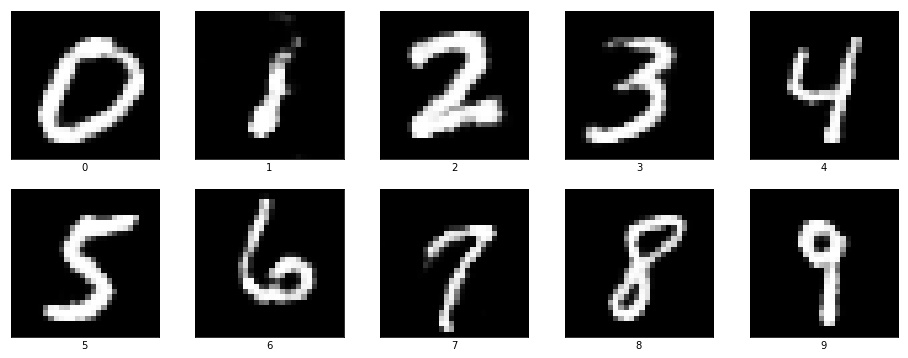

In [15]:
fig, axes = plt.subplots(nrows = 2, ncols = 5, figsize = (16, 6))
plt.setp(axes.flat, xticks = [], yticks = [])
for i, ax in enumerate(axes.flat):
    noise = np.random.uniform(0, 1, size = (1, LATENT_DIMENSION))
    condition = to_categorical(np.array([i]), LATENT_DIMENSION)
    generated_image = generator.predict([noise, condition]).reshape(IMAGE_HEIGHT, IMAGE_WIDTH)
    ax.imshow(generated_image, cmap = 'gray')
    ax.set_xlabel(str(i))
plt.show()

In [23]:
from matplotlib import colors

inputs, labels = next(iter(train_dataset))

1/1 [==============================] - 0s 76ms/step
[[[-0.0021849]
  [-0.0021849]
  [-0.0021849]
  ...
  [-0.0021849]
  [-0.0021849]
  [-0.0021849]]

 [[-0.0021849]
  [-0.0021849]
  [-0.0021849]
  ...
  [-0.0021849]
  [-0.0021849]
  [-0.0021849]]

 [[-0.0021849]
  [-0.0021849]
  [-0.0021849]
  ...
  [-0.0021849]
  [-0.0021849]
  [-0.0021849]]

 ...

 [[-0.0021849]
  [-0.0021849]
  [-0.0021849]
  ...
  [-0.0021849]
  [-0.0021849]
  [-0.0021849]]

 [[-0.0021849]
  [-0.0021849]
  [-0.0021849]
  ...
  [-0.0021849]
  [-0.0021849]
  [-0.0021849]]

 [[-0.0021849]
  [-0.0021849]
  [-0.0021849]
  ...
  [-0.0021849]
  [-0.0021849]
  [-0.0021849]]]
tf.Tensor(
[[[0.         0.05040158 0.1766519  ... 0.08971862 0.00777488 0.44444445]
  [0.         0.05037143 0.17769061 ... 0.0898349  0.00777488 0.44444445]
  [0.         0.05101332 0.17873324 ... 0.08995117 0.00777488 0.44444445]
  ...
  [0.         0.04875648 0.22083327 ... 0.09638395 0.00777488 0.7777778 ]
  [0.         0.04875577 0.22113928 ... 0

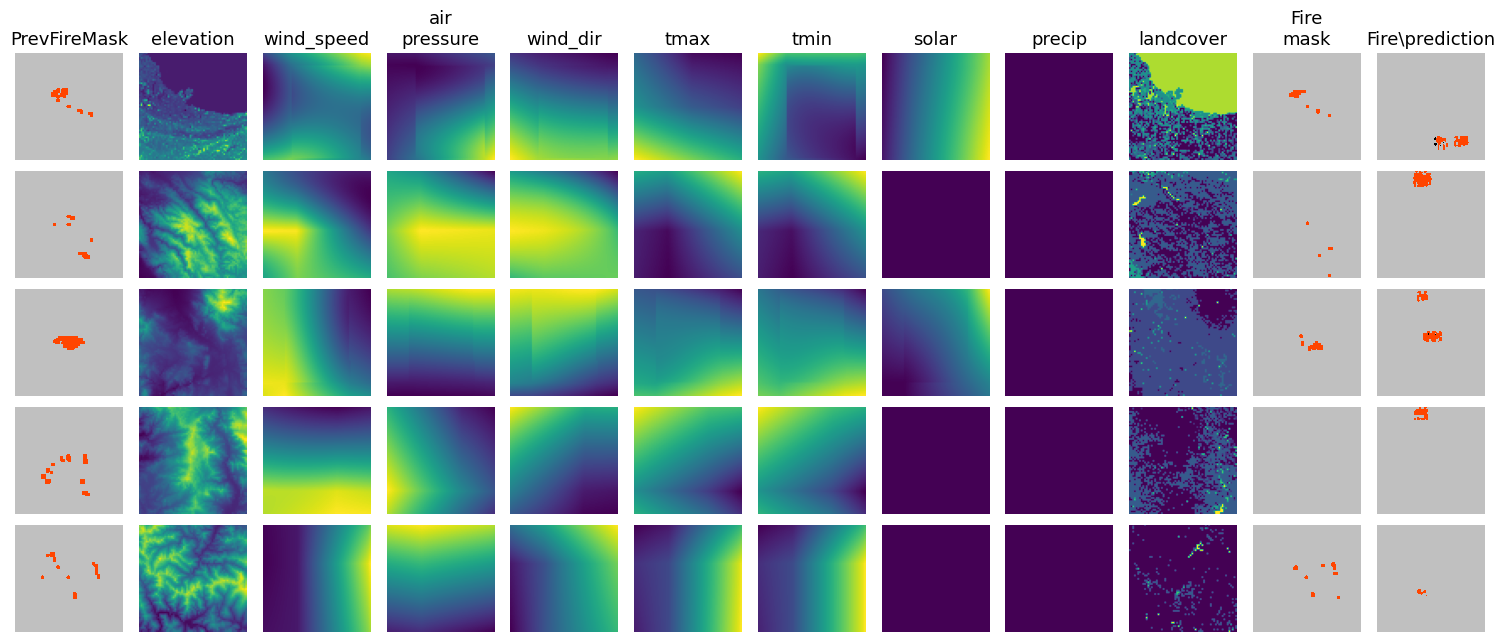

In [24]:
TITLES = ['PrevFireMask', 'elevation', 'wind_speed', 'air\npressure', 'wind_dir', 'tmax', 'tmin',
                  'solar', 'precip', 'landcover',  'Fire\nmask', 'Fire\prediction']

# Number of rows of data samples to plot
n_rows = 5
# Number of data variables
n_features = inputs.shape[3]
# Variables for controllong the color map for the fire masks
CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
BOUNDS = [-1, -0.1, 0.001, 1]
NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)


fig = plt.figure(figsize=(15,6.5))
noise = np.random.uniform(0, 1, size = (BATCH_SIZE, LATENT_DIMENSION))
generated_image = generator.predict([noise, inputs])
print(generated_image[0])
print(inputs[0])
print(labels[0])

for i in range(n_rows):
    for j in range(n_features + 2):
        plt.subplot(n_rows, n_features + 2, i * (n_features + 2) + j + 1)
        if i == 0:
            plt.title(TITLES[j], fontsize=13)
        if j == 0:
            plt.imshow(inputs[i, :, :, 0], cmap=CMAP, norm=NORM)
        if j > 0 and j < n_features:
            plt.imshow(inputs[i, :, :, j], cmap='viridis')
        if j == n_features:
            plt.imshow(labels[i, :, :], cmap=CMAP, norm=NORM)
        if j == n_features + 1:
            plt.imshow(generated_image[i,:,:], cmap=CMAP, norm=NORM)
        plt.axis('off')
plt.tight_layout()
plt.show()

In [25]:
generator.save('./generator.h5')
discriminator.save('./discriminator.h5')

In [26]:
np.save('./losses/discriminator_loss', discriminator_loss_history)
np.save('./losses/generator_loss', generator_loss_history)

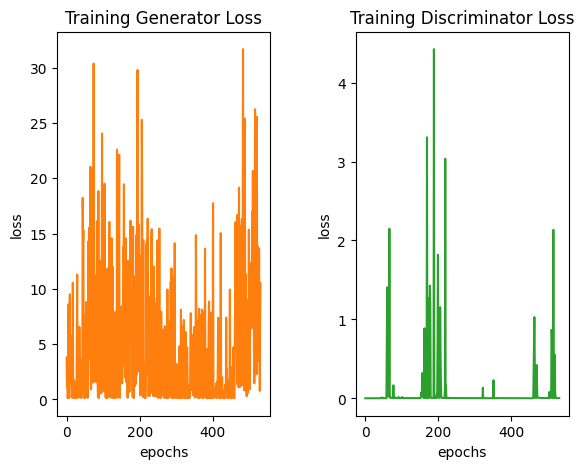

In [29]:
fig, axs = plt.subplots(1, 2)
x = np.array(range(532))
axs[0].set_title('Training Generator Loss')
axs[0].plot(x, generator_loss_history, 'tab:orange')
axs[1].set_title('Training Discriminator Loss')
axs[1].plot(x, discriminator_loss_history, 'tab:green')
for ax in axs:
    ax.set(xlabel='batch', ylabel='BCEloss')
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4,hspace=0.4)
plt.show()

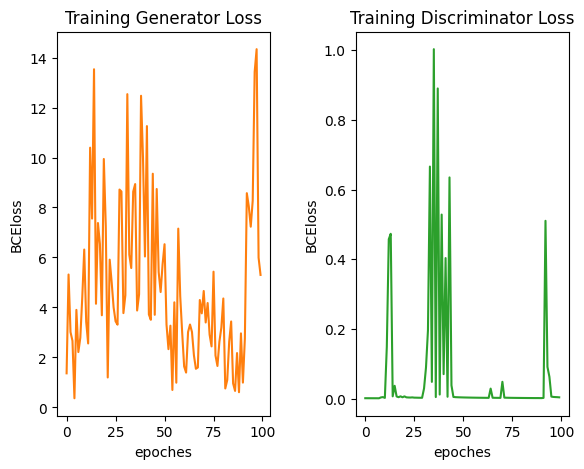

In [31]:
fig, axs = plt.subplots(1, 2)
x = np.array(range(100))
axs[0].set_title('Training Generator Loss')
axs[0].plot(x, np.array(generator_loss_history[:500]).reshape(-1,5).mean(axis=1), 'tab:orange')
axs[1].set_title('Training Discriminator Loss')
axs[1].plot(x, np.array(discriminator_loss_history[:500]).reshape(-1,5).mean(axis=1), 'tab:green')
for ax in axs:
    ax.set(xlabel='epoches', ylabel='BCEloss')
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4,hspace=0.4)
plt.show()